In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
sns.set_palette("bright")
RC_PARAMS = {
    "lines.linewidth": 2,
    "axes.labelsize": 16,
    "axes.labelweight": "bold",
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "axes.formatter.use_mathtext": True,
    "figure.figsize": (12, 5),
#     "figure.labelsize": 16,
#     "figure.labelweight": "bold",
    "figure.titleweight": "bold",
    "figure.titlesize": 18,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.fancybox": True,
    "text.usetex": False,
    "mathtext.fontset": "stix",
    "mathtext.default": "bf",
    "font.family": "STIXGeneral",
    "font.weight": "bold",
}
plt.rcParams.update(RC_PARAMS)

In [4]:
from scipy.integrate import quad,simpson
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [5]:
from distr_tools import mixture_dist

Plotting Parameters

In [6]:
fsize = 4.
folder = '../fig/'

Helper functions

In [7]:
class mv_uniform:
    def __init__(self,unif_list):
        self.d = len(unif_list)
        self.dist_list = unif_list
        
    def pdf(self,x):
        this_x = np.atleast_2d(x)
        pdf_out = np.ones(len(this_x))
        for i,pdf in enumerate(self.dist_list):
            pdf_out *= pdf.pdf(this_x[:,i])
        return pdf_out

In [8]:
class dci_update:
    def __init__(self,init_dist,predict_dist,observed_dist,Qmap):
        self.init = init_dist
        self.predict = predict_dist
        self.observe = observed_dist
        self.Qmap = Qmap
        
    def pdf(self,lam):
        pdf_out = np.zeros(len(lam))
        lam_init_pdf = self.init.pdf(lam)
        q = Qmap(lam)
        q_obs_pdf = self.observe.pdf(q)
        q_pred_pdf = self.predict.pdf(q)
        
        nonzero = np.logical_and(lam_init_pdf > 0., q_obs_pdf > 0.)
        
        r_ratio = q_obs_pdf[nonzero]/q_pred_pdf[nonzero]
        
        pdf_out[nonzero] = lam_init_pdf[nonzero]*r_ratio
        
        return pdf_out
        
        
        

### MSE Lp convergence Example

In [9]:
tripeaks = [sps.norm(-1+i,[0.2,0.3,0.4][i]) for i in range(3)]
obs_dist = mixture_dist(tripeaks,[1/5,2/5,3/5])

init_dist = sps.multivariate_normal(np.zeros(2),np.eye(2))

def Qmap(lam):
    lam1,lam2 = np.atleast_2d(lam).T
    return lam1+lam2

# exact distribution is sum of normals
pred_dist = sps.norm(0,np.sqrt(2))

# exact update distribution
tri_exact_update = dci_update(init_dist,pred_dist,obs_dist,Qmap)

In [10]:
# Parameter Space Evaluation Matrices
lamx,lamy = [np.linspace(-2.5,2.5,250+i) for i in range(2)]
lamX,lamY = np.meshgrid(lamx,lamy)
lamXY_eval = np.stack([lamX.reshape(-1,),lamY.reshape(-1,)],axis=1)

In [11]:
# # Plot the exact observed and predicted
# qx = np.linspace(-4,4,250)
# plt.plot(qx,obs_dist.pdf(qx))
# plt.plot(qx,pred_dist.pdf(qx))
# pred_sample = Qmap(init_dist.rvs(1000))
# plt.hist(pred_sample,density=True,alpha=0.5)

In [12]:
# # Plot the exact update
# up_exact_pdf = tri_exact_update.pdf(lamXY_eval).reshape(lamX.shape)
# plt.contour(lamX,lamY,up_exact_pdf)

Generate the sample for evaluating KDEs of the observed distribution

In [13]:
ex1_rng = np.random.default_rng(1234562)

n_obs_max = 10000
K_rep = 75
obs_sample = obs_dist.rvs([K_rep,n_obs_max],random_state=ex1_rng)

**Compute AMISE Bandwidth**

Compute AMISE bandwidth for a gaussian kernel density estimate that is a mixture of gaussian distributions.

In [14]:
def norm_prime_prime(t):
    x = np.array(t, dtype=float)
    term = (x**2-1)*np.exp(-x**2/2)
    weight = 1/np.sqrt(2*np.pi)
    return term*weight

# note that this function depends on obs_dist defined above
def true_pi_prime_prime(q):  
    x = np.array(q, dtype=float)
    out = np.zeros_like(x)
    
    for k in np.arange(len(obs_dist.pdfs)):
        y = (x- obs_dist.pdfs[k].mean())/obs_dist.pdfs[k].std()
        out += obs_dist.weights[k]*norm_prime_prime(y)/(obs_dist.pdfs[k].std()**3)
    
    return out

# compute the squared integral
f = lambda q: true_pi_prime_prime(q)**2
Rprimeprime,err = quad(f,-6,40)

# compute hmise
RK = 1/(2*np.sqrt(np.pi)) # computable by hand
mu2K = 1 # computable by hand
AMISE_factor = RK/(mu2K**2*Rprimeprime)
print('Optimal Factor: ', AMISE_factor)


Optimal Factor:  0.006332286651897054


In [15]:
# define appropriate bandwidths for sample set
n_list = np.geomspace(100,n_obs_max,5).astype(int)

print('Optimal Bandwidth: ')
h_mise_list = []
for n in n_list:
    h_mise = (1/n*AMISE_factor)**(1./5.)
    h_mise_list.append(h_mise)
    print('n={}\t'.format(n),h_mise)

Optimal Bandwidth: 
n=100	 0.14464789345367457
n=316	 0.11491446427918749
n=1000	 0.09126665073818443
n=3162	 0.0724969507171215
n=10000	 0.057585363589366126


**Compute KDEs with optimal bandwidths**

In [16]:
obs_kde_dict = {}
for n,h in zip(n_list,h_mise_list):
    obs_kde_dict[n] = []
    # compute kde over different sample sets
    for K in range(K_rep):
        kde_factor = h/np.std(obs_sample[K,0:n],ddof=1)
        this_kde = sps.gaussian_kde(obs_sample[K,0:n],
                                    bw_method=kde_factor)
        obs_kde_dict[n].append(this_kde)

In [17]:
# shows observed vs. approximate
# plt.plot(qx,obs_dist.pdf(qx),color='k')
# for key in enumerate(obs_kde_dict.keys()):
#     for K,kde in obs_kde_dict[key][0:5]:
#         plt.plot(qx,kde.pdf(qx),ls='--',
#                  label='$n_{{ {} }}={}$'.format(i,key))
# plt.legend()

**Compute Lp-Error for Observed Distributions**

In [18]:
def Lp_err(x,dist1,dist2,p):
    return np.abs(dist1.pdf(x)-dist2.pdf(x))**p

In [19]:
obs_err_matrix = np.empty([len(n_list),K_rep])

for i,key in enumerate(obs_kde_dict.keys()):
    for j,kde in enumerate(obs_kde_dict[key]):
        # note: using simpson's rule is fast and accurate enough for
        # this example
        qx = np.linspace(-4,4,250)        
        this_err = simpson(Lp_err(qx,obs_dist,kde,2),qx)        
#         this_err = quad(lambda x: Lp_err(x,obs_dist,kde,2),-4,5)[0]
        obs_err_matrix[i,j] = this_err

-0.7735201308289252


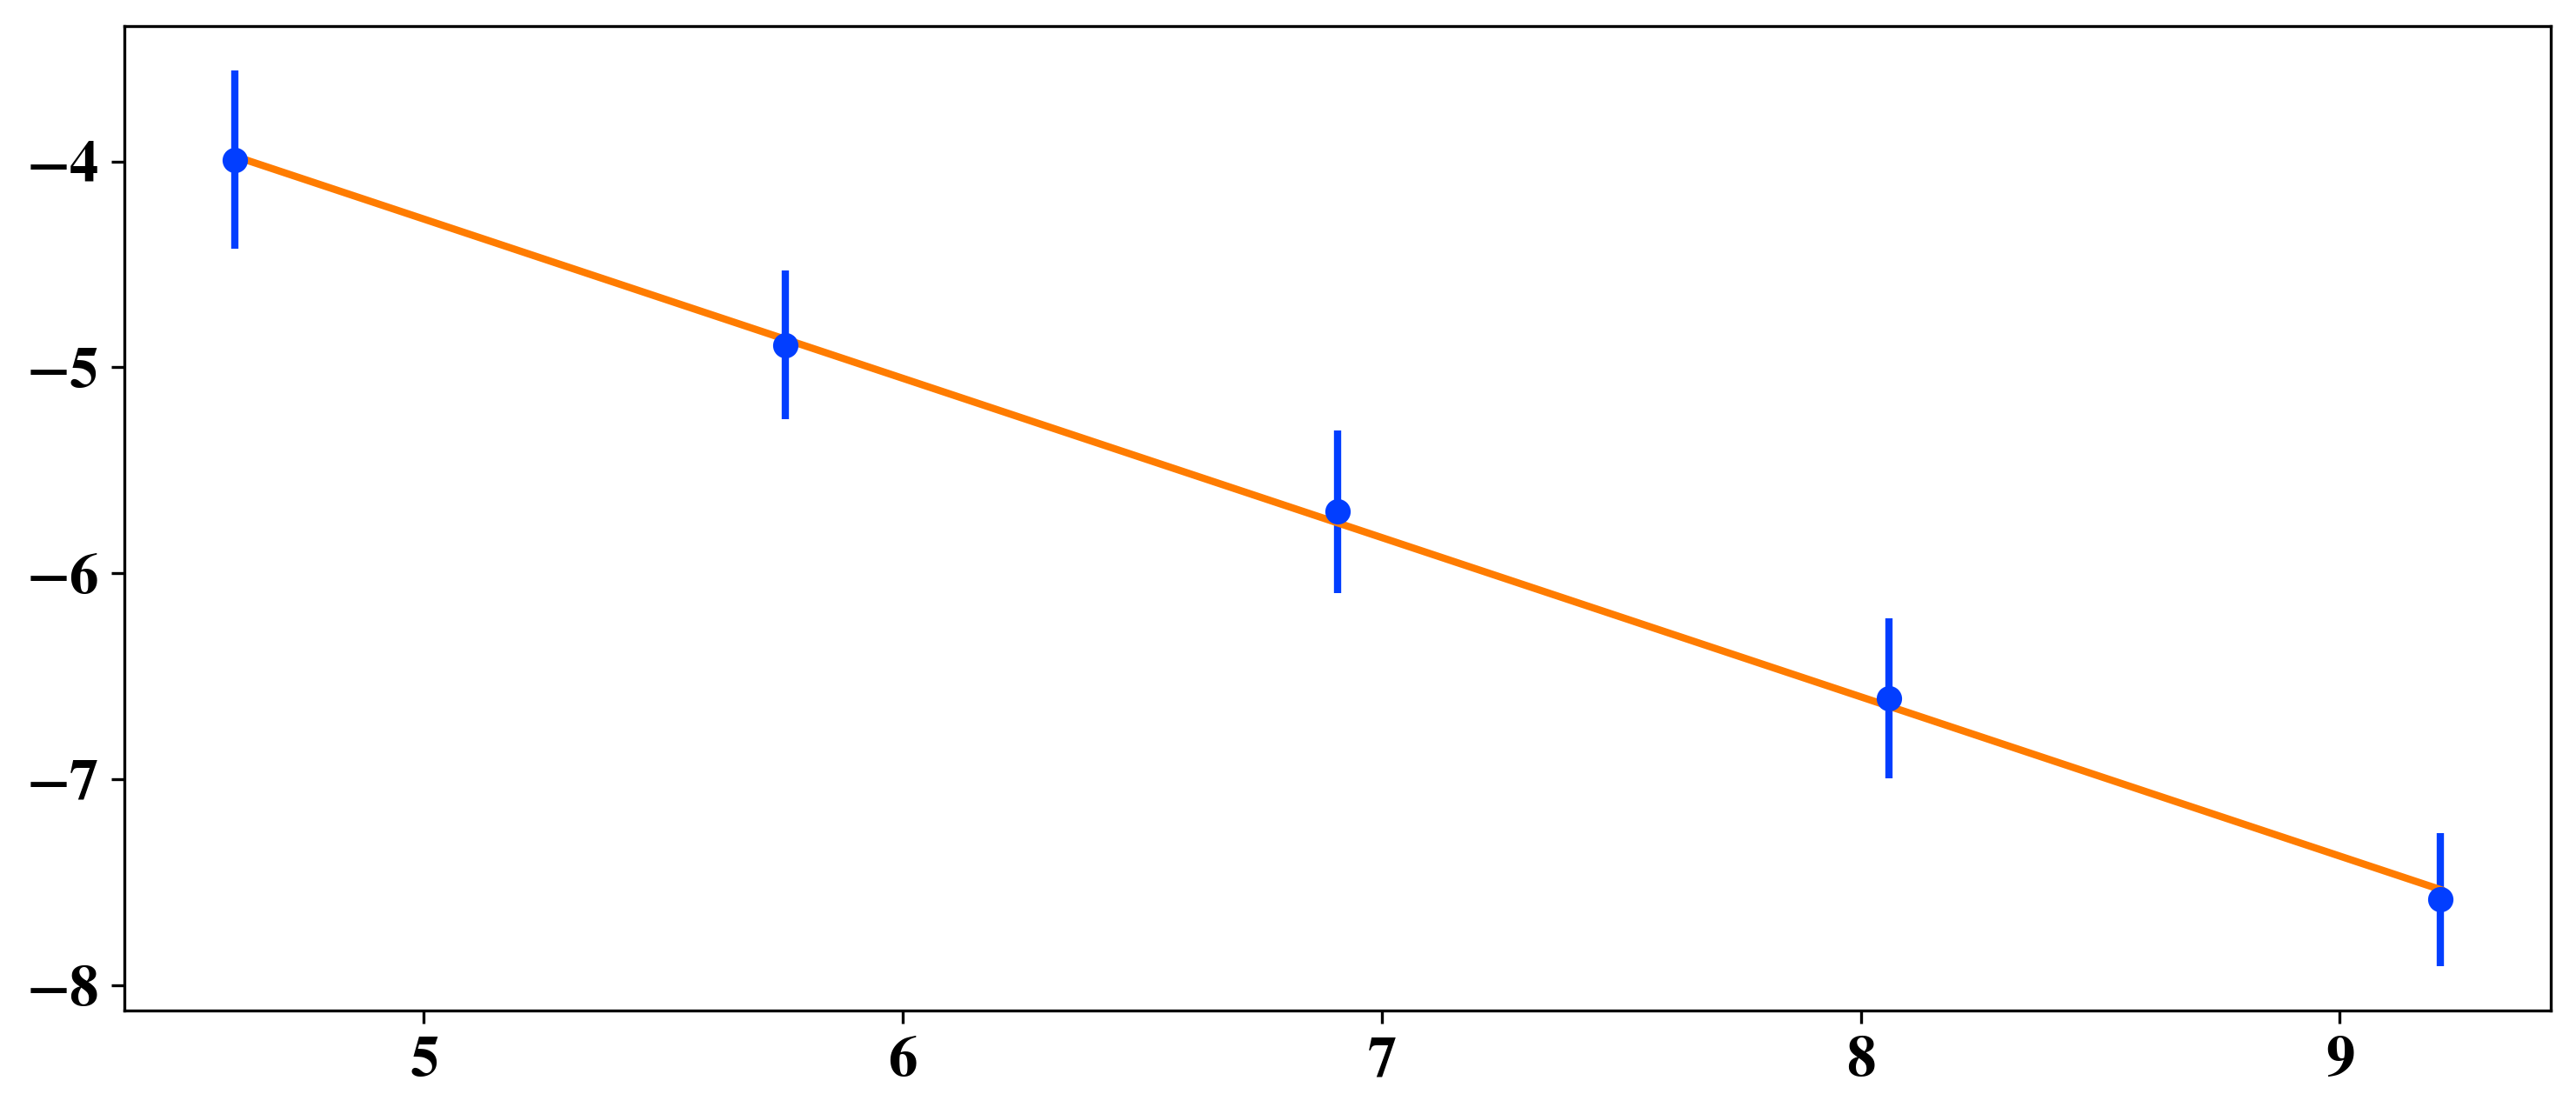

In [20]:
# Convergence plot with error bars
errsy = np.log(obs_err_matrix).std(axis=1)
out_err = sps.linregress(np.log(n_list),np.log(np.mean(obs_err_matrix,axis=1)))
print(out_err.slope)

this_x,this_y = np.log(n_list),np.log(np.mean(obs_err_matrix,axis=1))
plt.errorbar(this_x,this_y,yerr=errsy,
             marker='o',ls='None')
plt.plot(this_x,out_err.intercept+this_x*out_err.slope)

**Compute the Update Lp-Error**

In [21]:
approx_update_dict = {}
for n,h in zip(n_list,h_mise_list):
    approx_update_dict[n] = []
    # compute updates over different sample sets
    for K in range(K_rep):
        this_obs_kde = obs_kde_dict[n][K]
        this_update = dci_update(init_dist,pred_dist,this_obs_kde,Qmap)
        approx_update_dict[n].append(this_update)

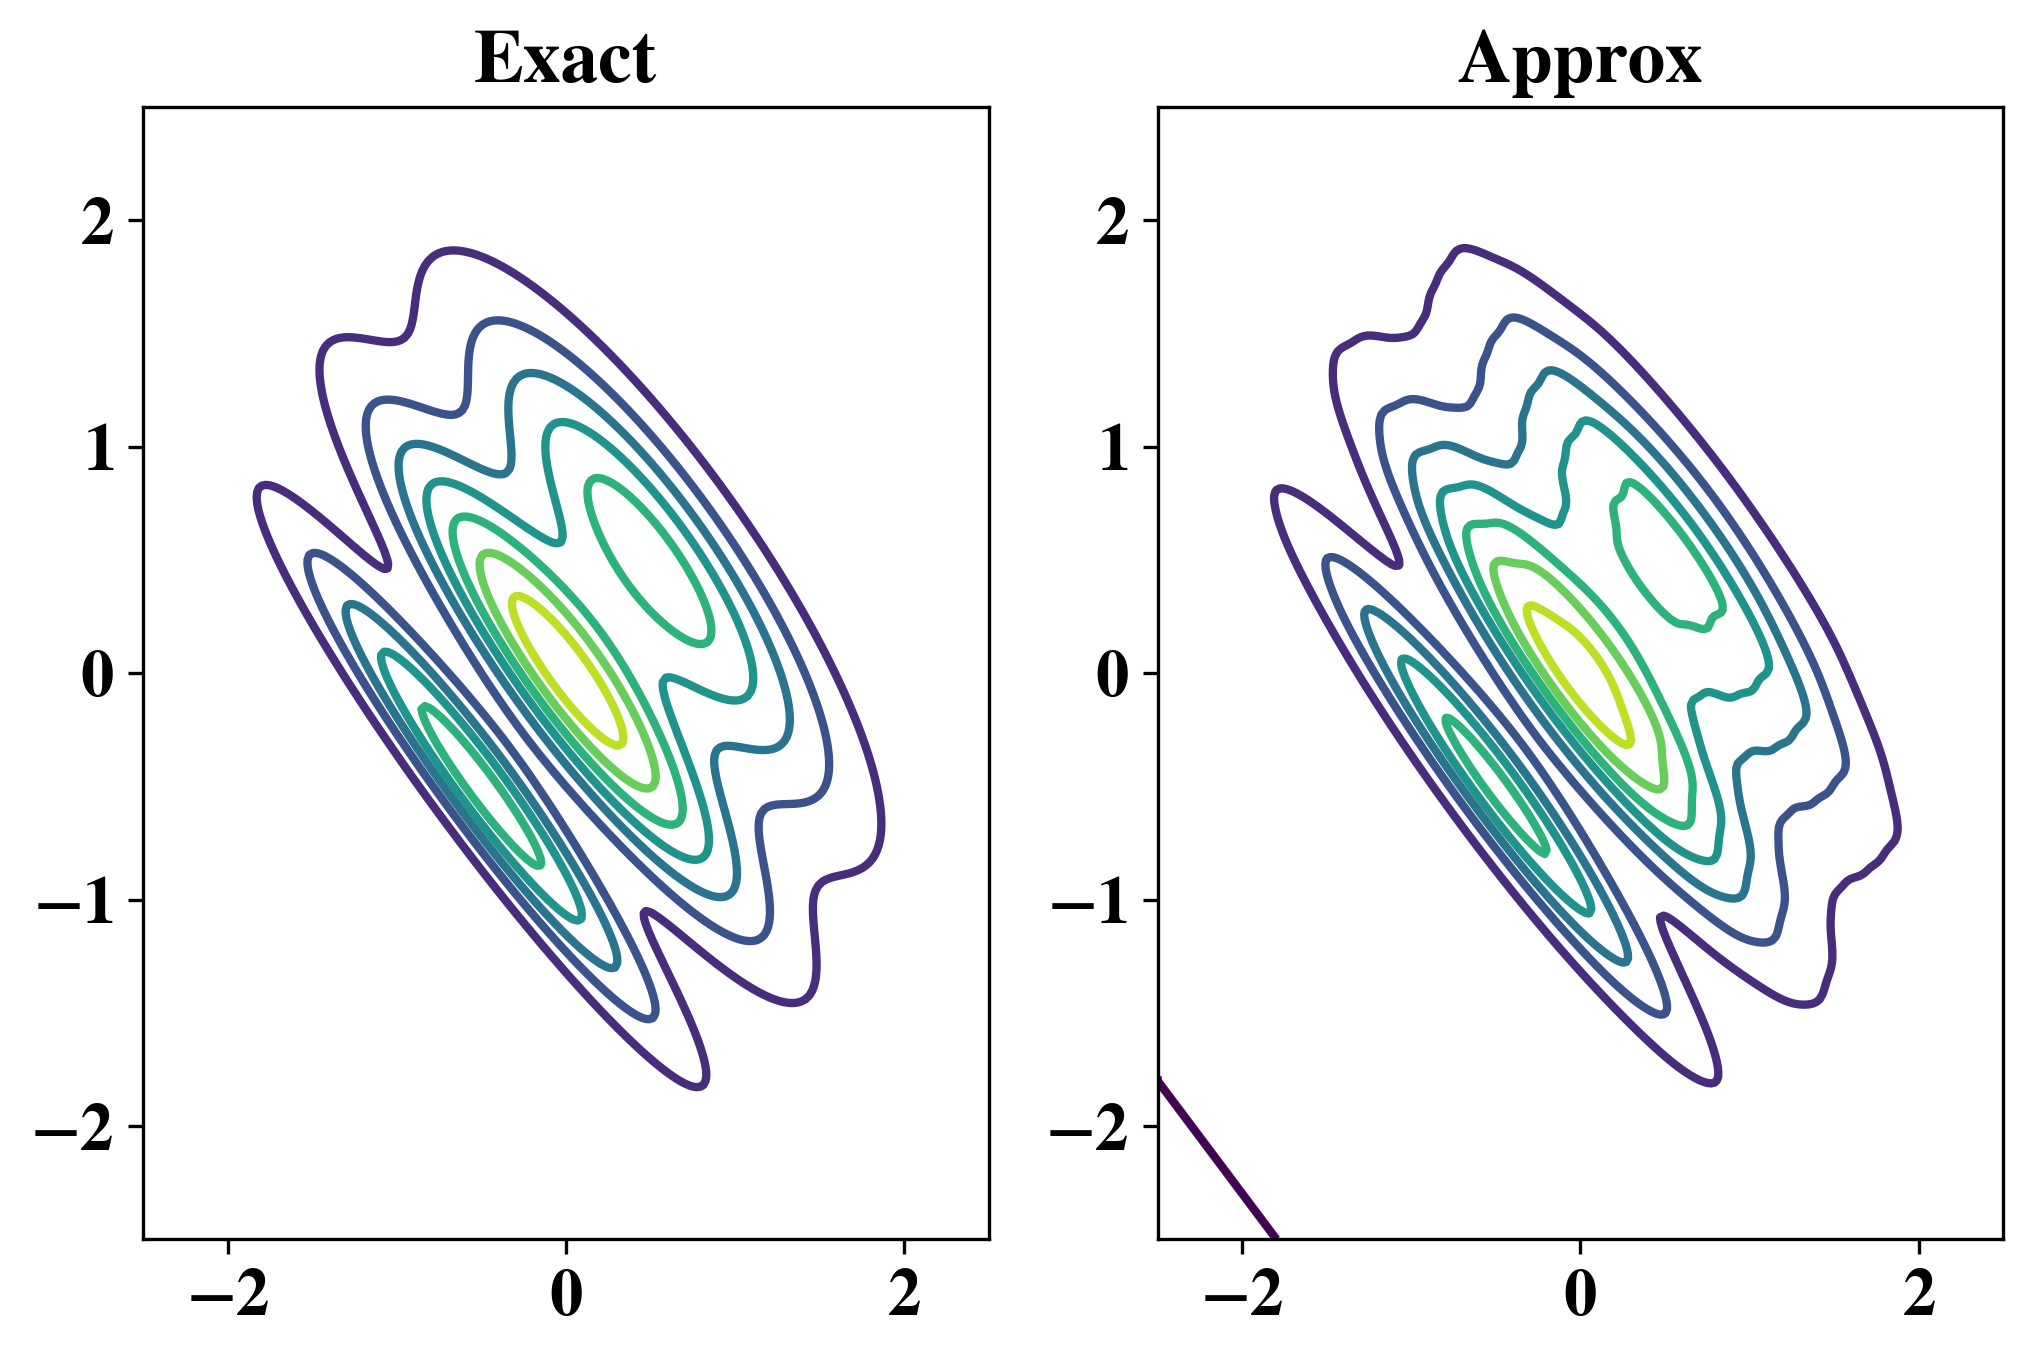

In [22]:
n = n_list[3]
exact_update_pdf = tri_exact_update.pdf(lamXY_eval).reshape(lamX.shape)
approx_update_pdf = approx_update_dict[n][0].pdf(lamXY_eval).reshape(lamX.shape)

pdf_list = [exact_update_pdf,approx_update_pdf]
this_min,this_max = np.array(pdf_list).min(),np.array(pdf_list).max()
pdf_titles = ['Exact','Approx']

fig,axes = plt.subplots(1,2)
fig.set_figwidth(2*fsize)
for i,ax in enumerate(axes):
    ax.contour(lamX,lamY,pdf_list[i],vmin=this_min,vmax=this_max)
    ax.set_title(pdf_titles[i])

In [23]:
update_err_matrix = np.empty([len(n_list),K_rep])

for i,key in enumerate(approx_update_dict.keys()):
    print('Working on... n=',key)
    for j,approx_dist in enumerate(approx_update_dict[key]):
        this_err = Lp_err(lamXY_eval,tri_exact_update,approx_dist,2).reshape(lamX.shape)
        update_err_matrix[i,j] = simpson(simpson(this_err,lamx),lamy)
print('Finished.')

Working on... n= 100
Working on... n= 316
Working on... n= 1000
Working on... n= 3162
Working on... n= 10000
Finished.


-0.7735156891426466


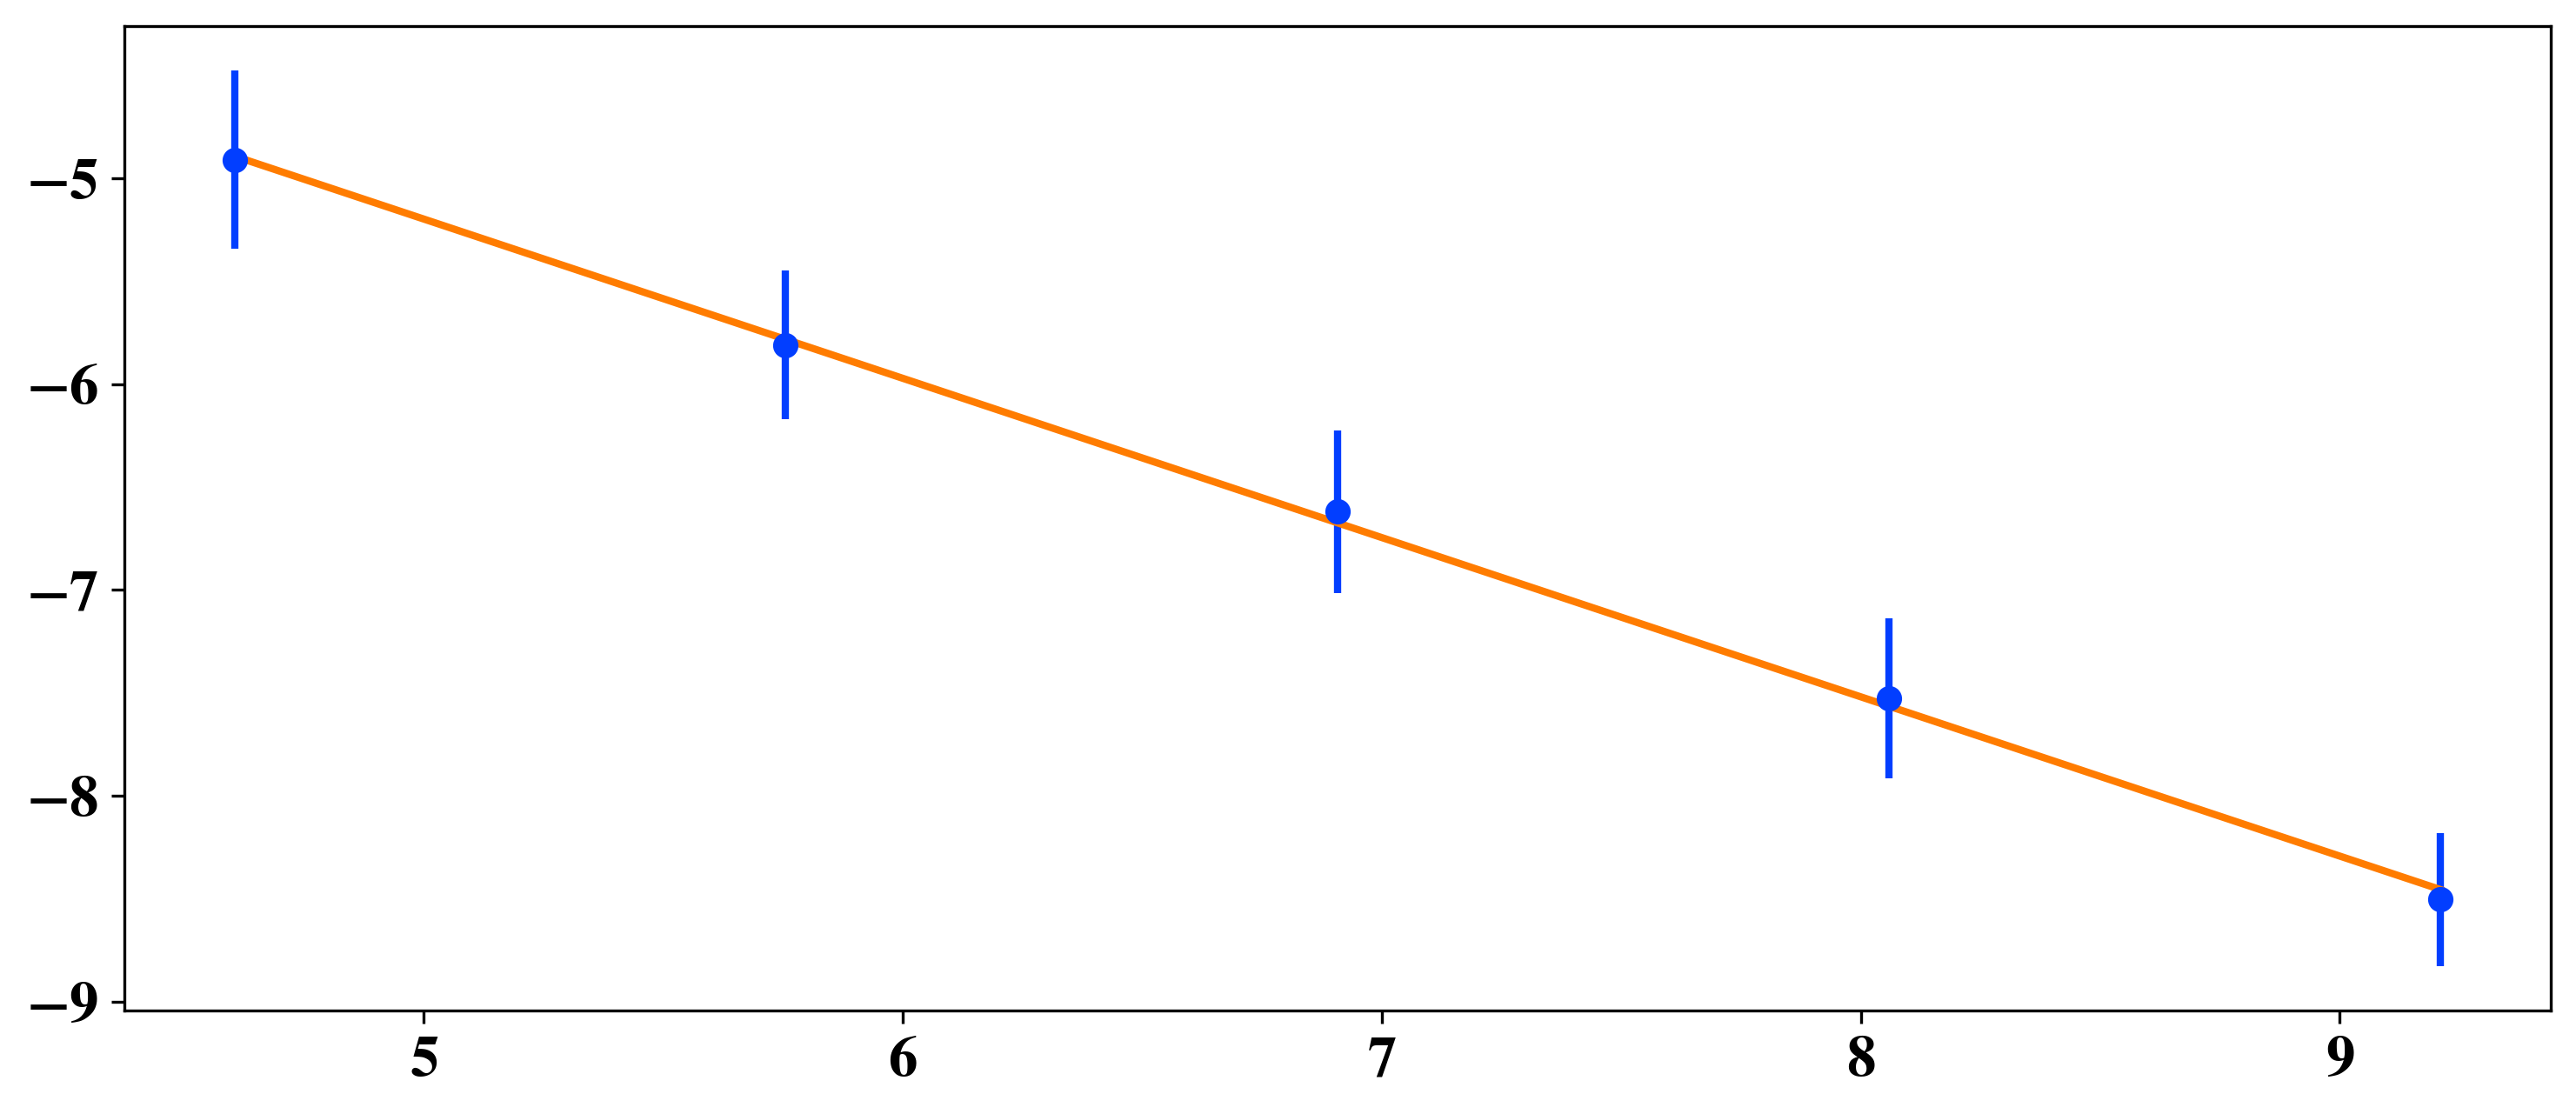

In [26]:
# Convergence plot with error bars
errsy = np.log(update_err_matrix).std(axis=1)
out_err = sps.linregress(np.log(n_list),np.log(np.mean(update_err_matrix,axis=1)))
print(out_err.slope)

this_x,this_y = np.log(n_list),np.log(np.mean(update_err_matrix,axis=1))
plt.errorbar(this_x,this_y,yerr=errsy,
             marker='o',ls='None')
plt.plot(this_x,out_err.intercept+this_x*out_err.slope)

### Specific Figures for Example

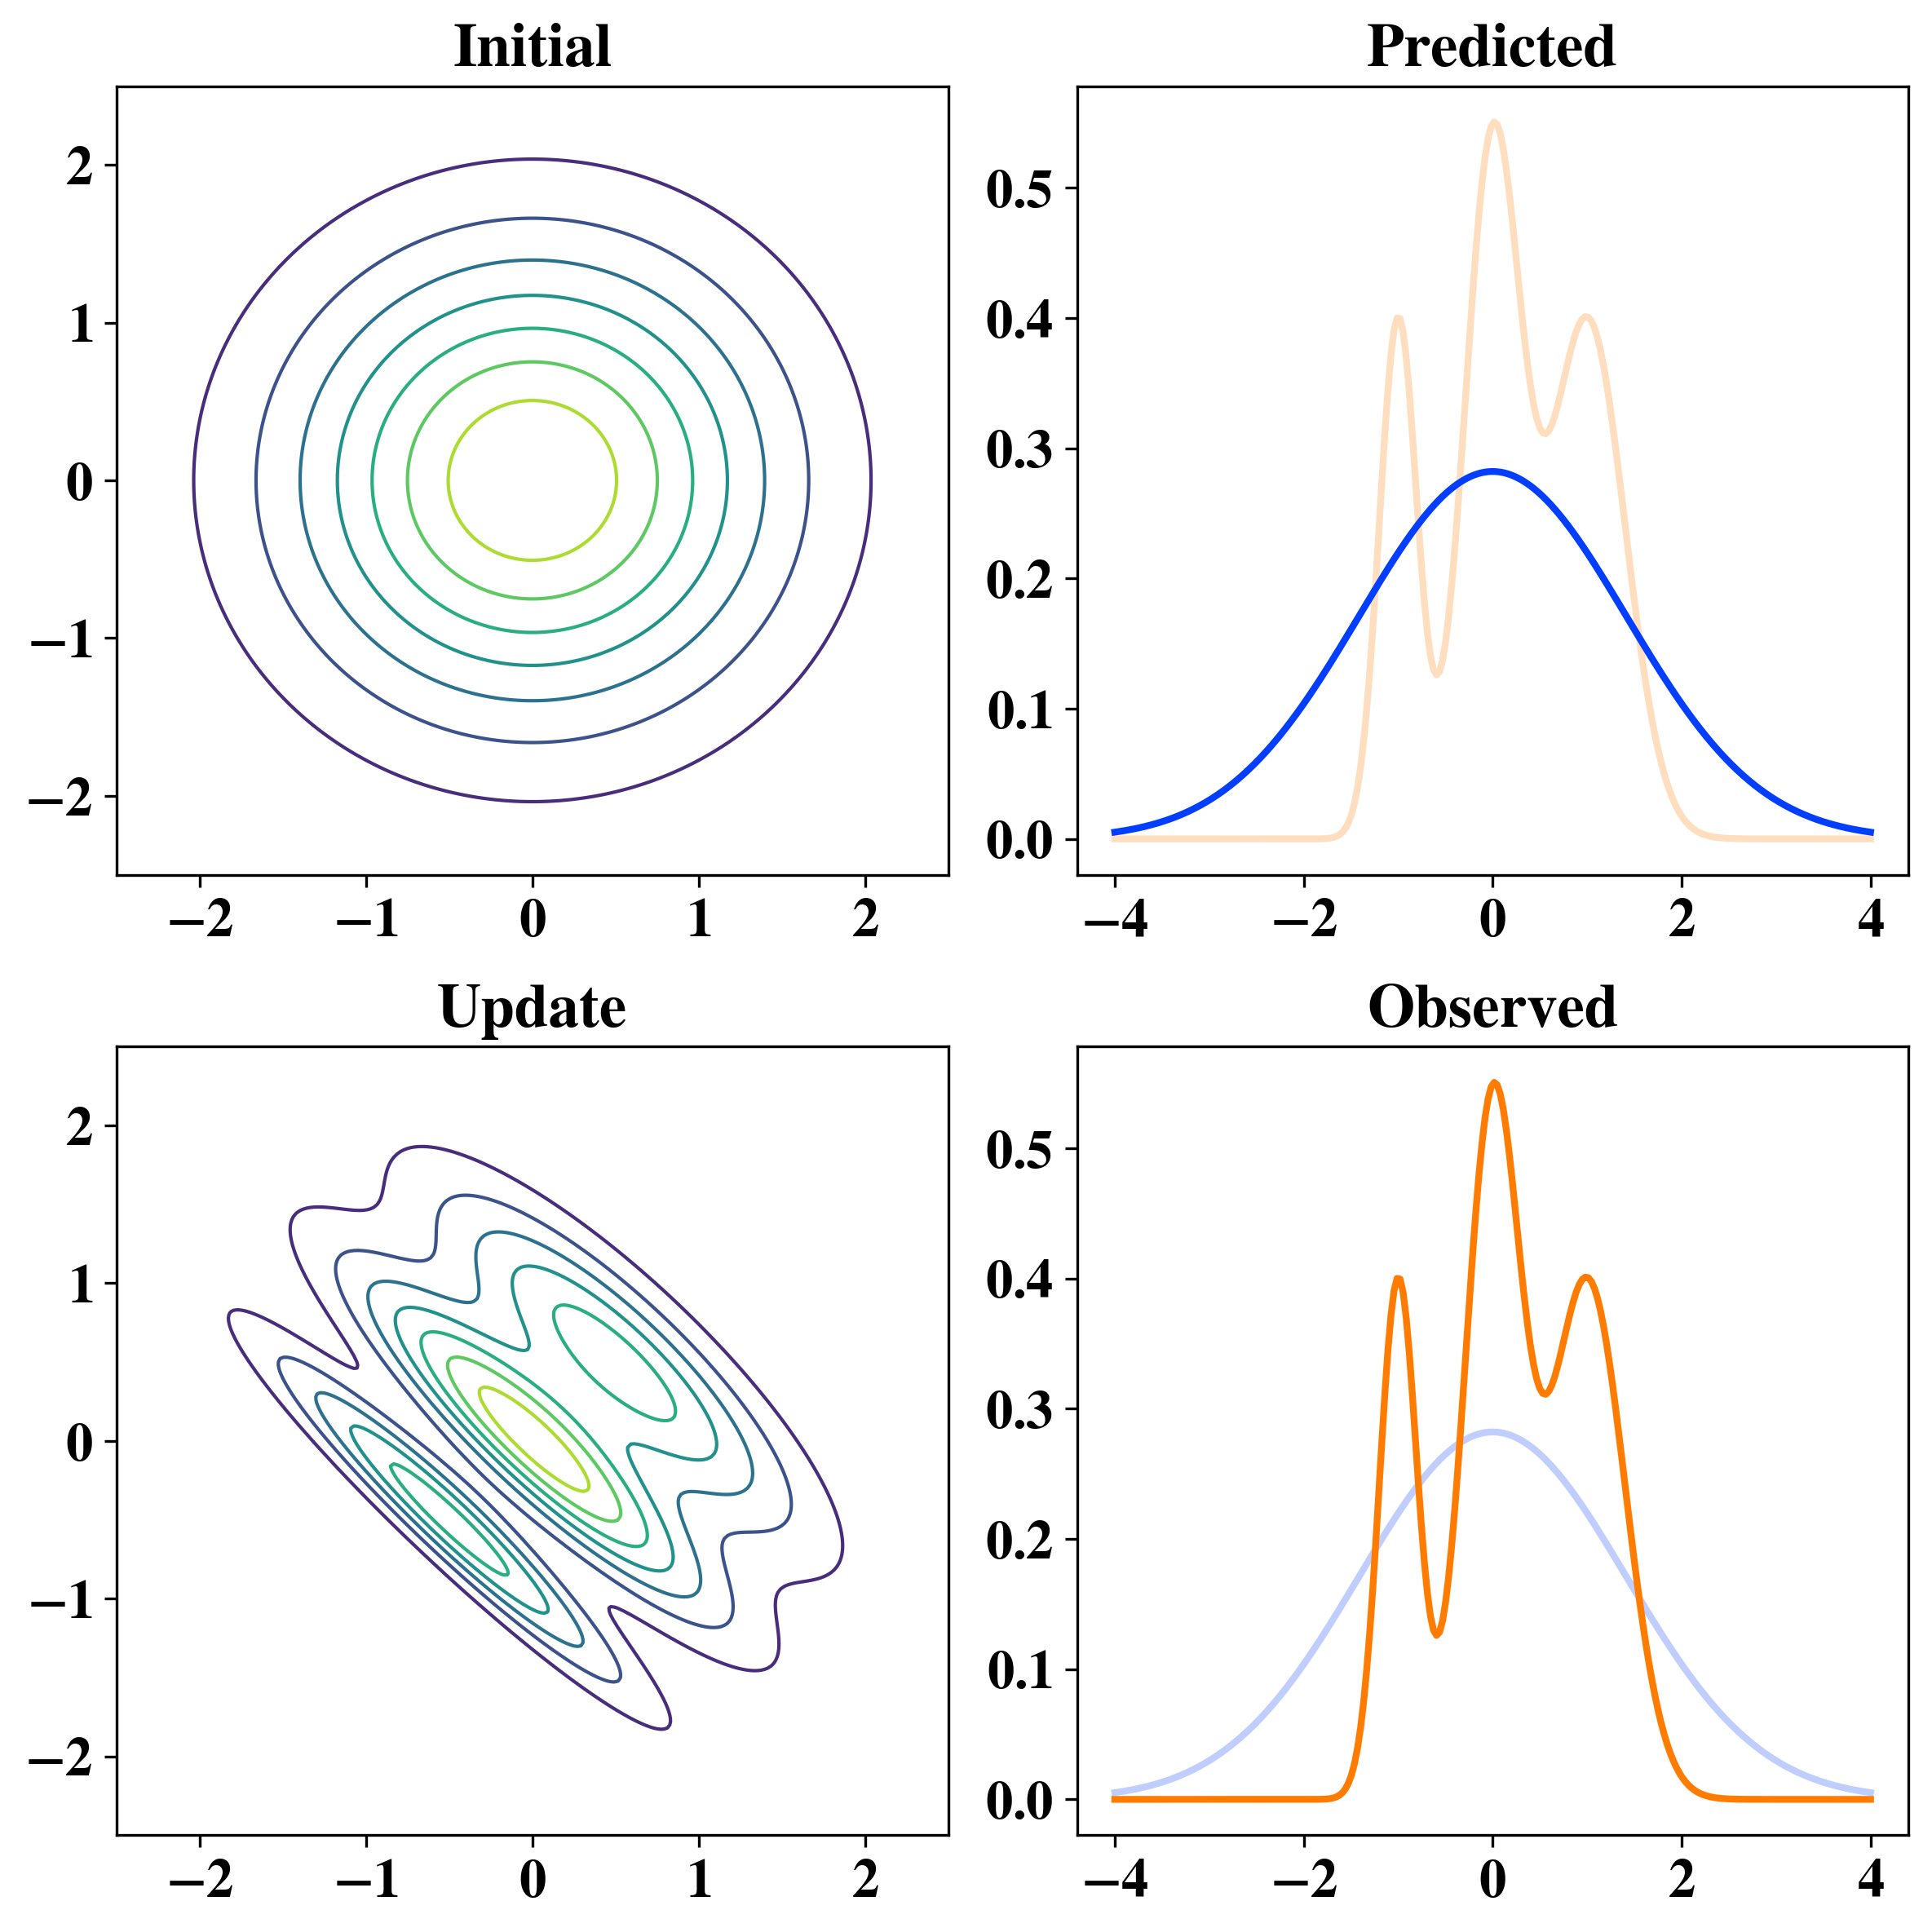

In [27]:
# setup of example figure
ex1_fig_setup, axes = plt.subplots(2,2)
ex1_fig_setup.set_figheight(2*fsize)
ex1_fig_setup.set_figwidth(2*fsize)

titles = [['Initial','Predicted'],['Update','Observed']]
lamZ = [init_dist.pdf(lamXY_eval).reshape(lamX.shape),
        tri_exact_update.pdf(lamXY_eval).reshape(lamX.shape)]
q_pdfs = [pred_dist.pdf(qx),obs_dist.pdf(qx)]
for i,ax_row in enumerate(axes):
    for j,ax in enumerate(ax_row):
        if j==0:
            ax.contour(lamX,lamY,lamZ[i],linewidths=1)
        else:
            ax.plot(qx,q_pdfs[j-i],color='C{}'.format(j-i),alpha=0.25)
            ax.plot(qx,q_pdfs[i],color='C{}'.format(i))
        ax.set_title(titles[i][j])
        
name_ex1_fig = 'ex1_fig_setup'
ex1_fig_setup.tight_layout()
ex1_fig_setup.savefig(folder+name_ex1_fig)

-0.7735201308289252
-0.7735156891426466


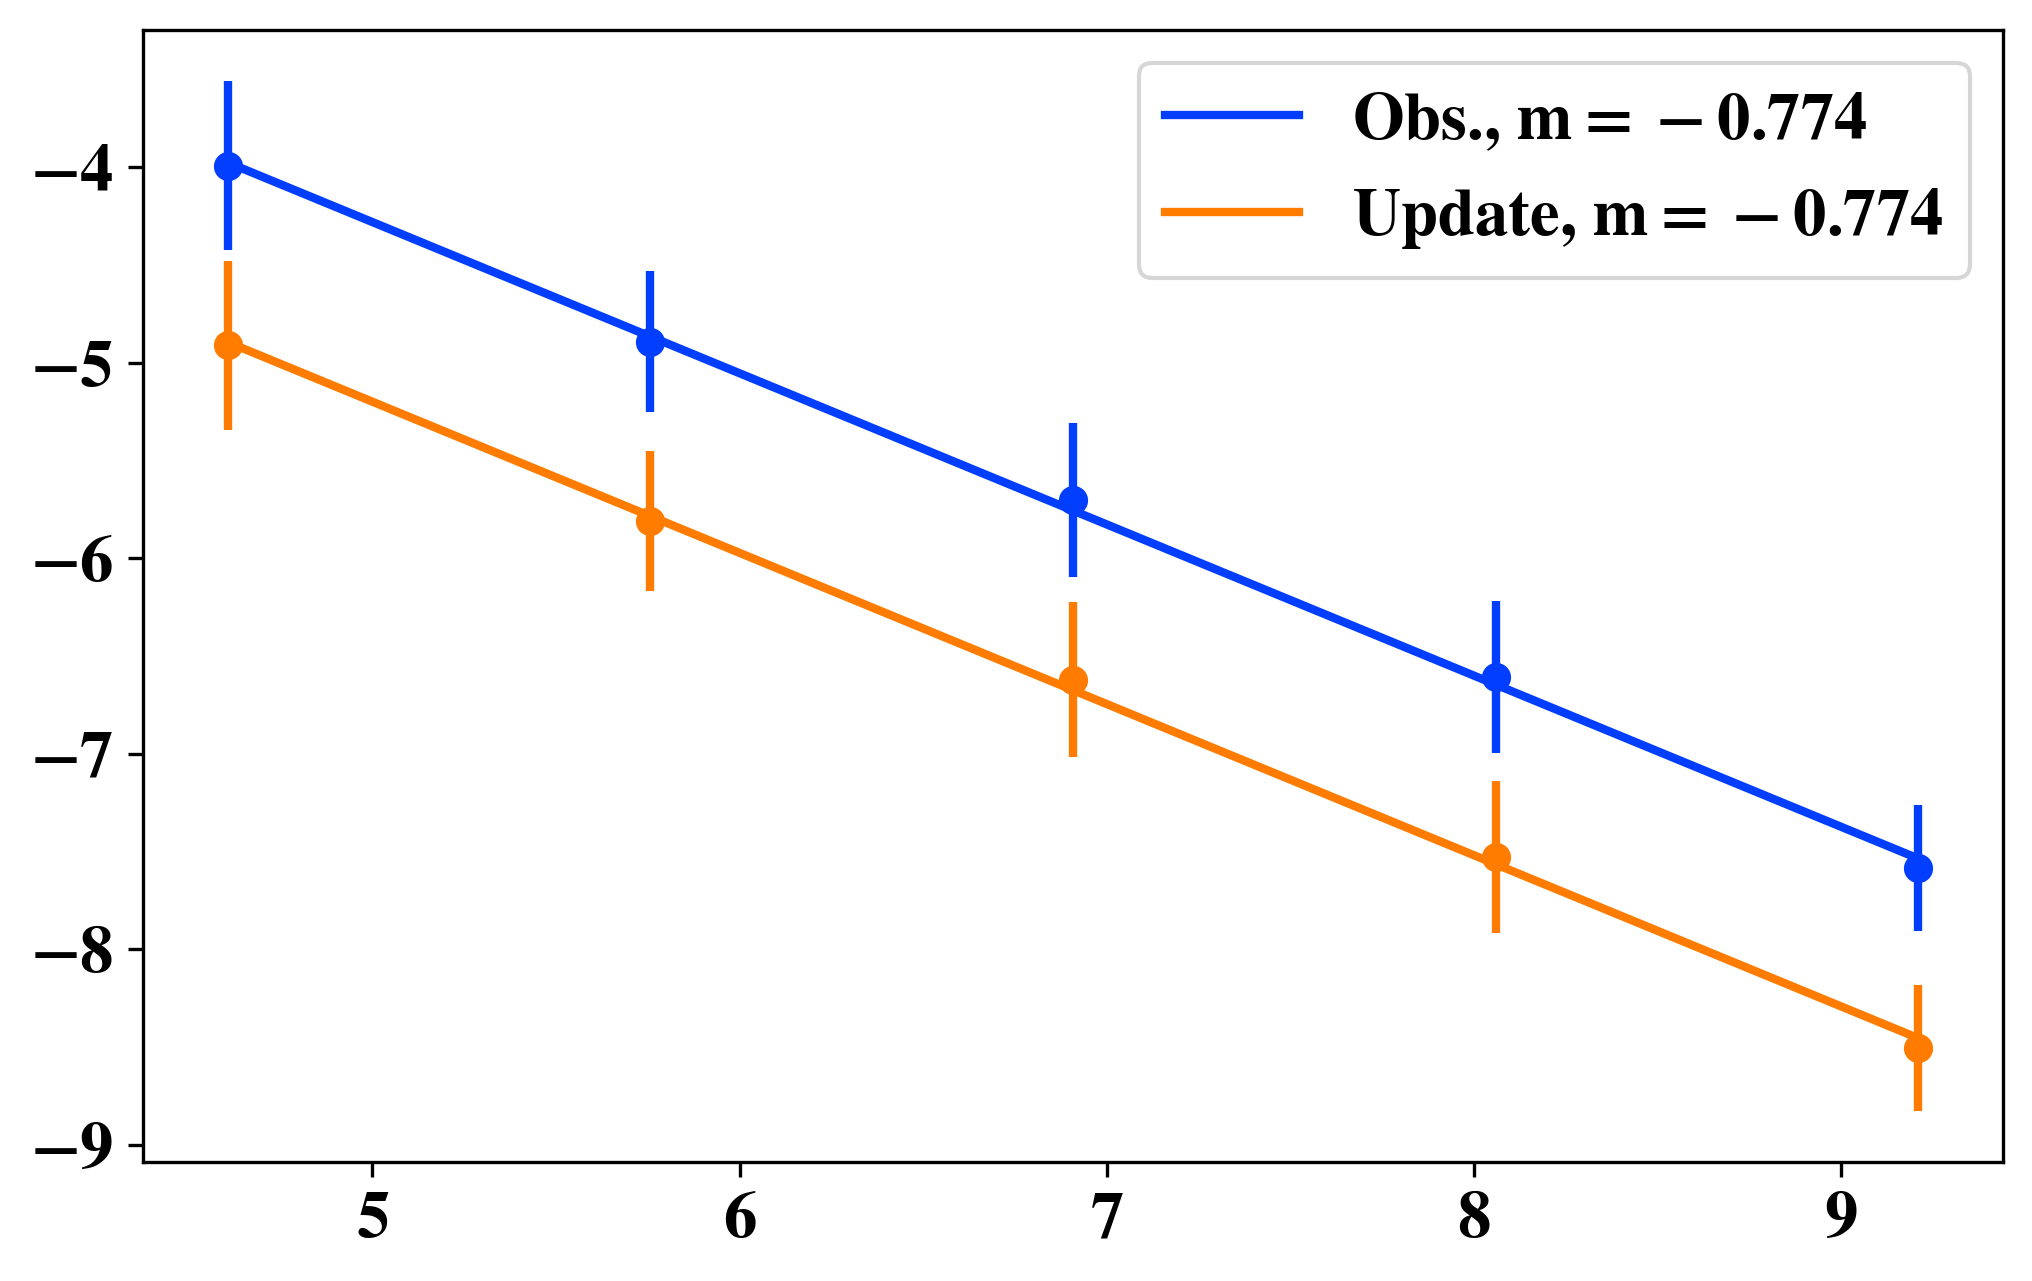

In [28]:
# convergence figure
ex1_fig_convergence, ax = plt.subplots(1)
ex1_fig_convergence.set_figwidth(2*fsize)

error_matrices = [obs_err_matrix,update_err_matrix]
line_label = ['Obs.','Update']
for i,err in enumerate(error_matrices):
    # Convergence plot with error bars
    errsy = np.log(err).std(axis=1)
    out_err = sps.linregress(np.log(n_list),np.log(np.mean(err,axis=1)))
    print(out_err.slope)

    this_x,this_y = np.log(n_list),np.log(np.mean(err,axis=1))
    ax.errorbar(this_x,this_y,yerr=errsy,
                 marker='o',ls='None')
    ax.plot(this_x,out_err.intercept+this_x*out_err.slope,
            color='C{}'.format(i),
            label='{}, $m={:0.3}$'.format(line_label[i],out_err.slope))
ax.legend()
name_ex1_fig2 = 'ex1_fig_convergence'
ex1_fig_convergence.savefig(folder+name_ex1_fig2)

### Almost Everywhere Example

Here is an example which illustrates the requirement of "almost everywhere" convergence.

Consider...

In [29]:
# initial lambda
lam1_dist = sps.uniform(0,1)
lam2_dist = sps.uniform(0,1)
init_dist = mv_uniform([lam1_dist,lam2_dist])

def Qmap(lam):
    lam1,lam2 = np.atleast_2d(lam).T
    return lam1+lam2

pred_dist = sps.triang(0.5,scale=2)
obs_dist = sps.triang(0.5,scale=1)

In [30]:
n_init = 5000
n_obs = 500

lam_init = np.stack([lam1_dist.rvs(n_init),lam2_dist.rvs(n_init)],
                    axis=1) 
q_pred = Qmap(lam_init)
q_obs = obs_dist.rvs(n_obs)

In [31]:
class approx_predict:
    def __init__(self,c,n):
        self.L_dist = sps.triang(1,loc=0,scale=c)
        self.R_dist = sps.triang(0,loc=c,scale=2-c)
        self.c = c
        self.n = n
        
    def pdf(self,x,this_n=None):
        n = self.n if this_n==None else this_n
        
        if type(x)==np.ndarray:
            pdf_out = np.zeros_like(x)
            xL = x[x <= self.c]
            xR = x[x > self.c]
            L_pdf = 1/2*self.L_dist.pdf(xL) 
            L_pdf += 1/n * sps.uniform(0,1.).pdf(xL)
            R_pdf = 1/2*self.R_dist.pdf(xR)*((n-2)/n)
            pdf_out[x<=self.c] = L_pdf
            pdf_out[x>self.c] = R_pdf
        else:
            if x <= self.c:
                pdf_out = 1/2*self.L_dist.pdf(x) 
                pdf_out += 1/n*sps.uniform(0,1).pdf(x)
            else:
                pdf_out = 1/2*self.R_dist.pdf(x)*((n-2)/n)
            
        return pdf_out

In [32]:
# # check that approximation integrates to 1 on domain
# # remember n>2.
# quad(lambda x: pred_approx.pdf(x,3),-0.5,2.5)

In [33]:
# # check plot visualization
# x = np.linspace(-0.5,2.5,150)
# plt.plot(x,pred_dist.pdf(x))
# # plt.hist(q_pred,density=True,
# #          edgecolor='k',alpha=0.5,color='xkcd:sky blue')
# plt.plot(x,pred_approx.pdf(x,4))
# plt.plot(x,obs_dist.pdf(x))

Figure of Setup

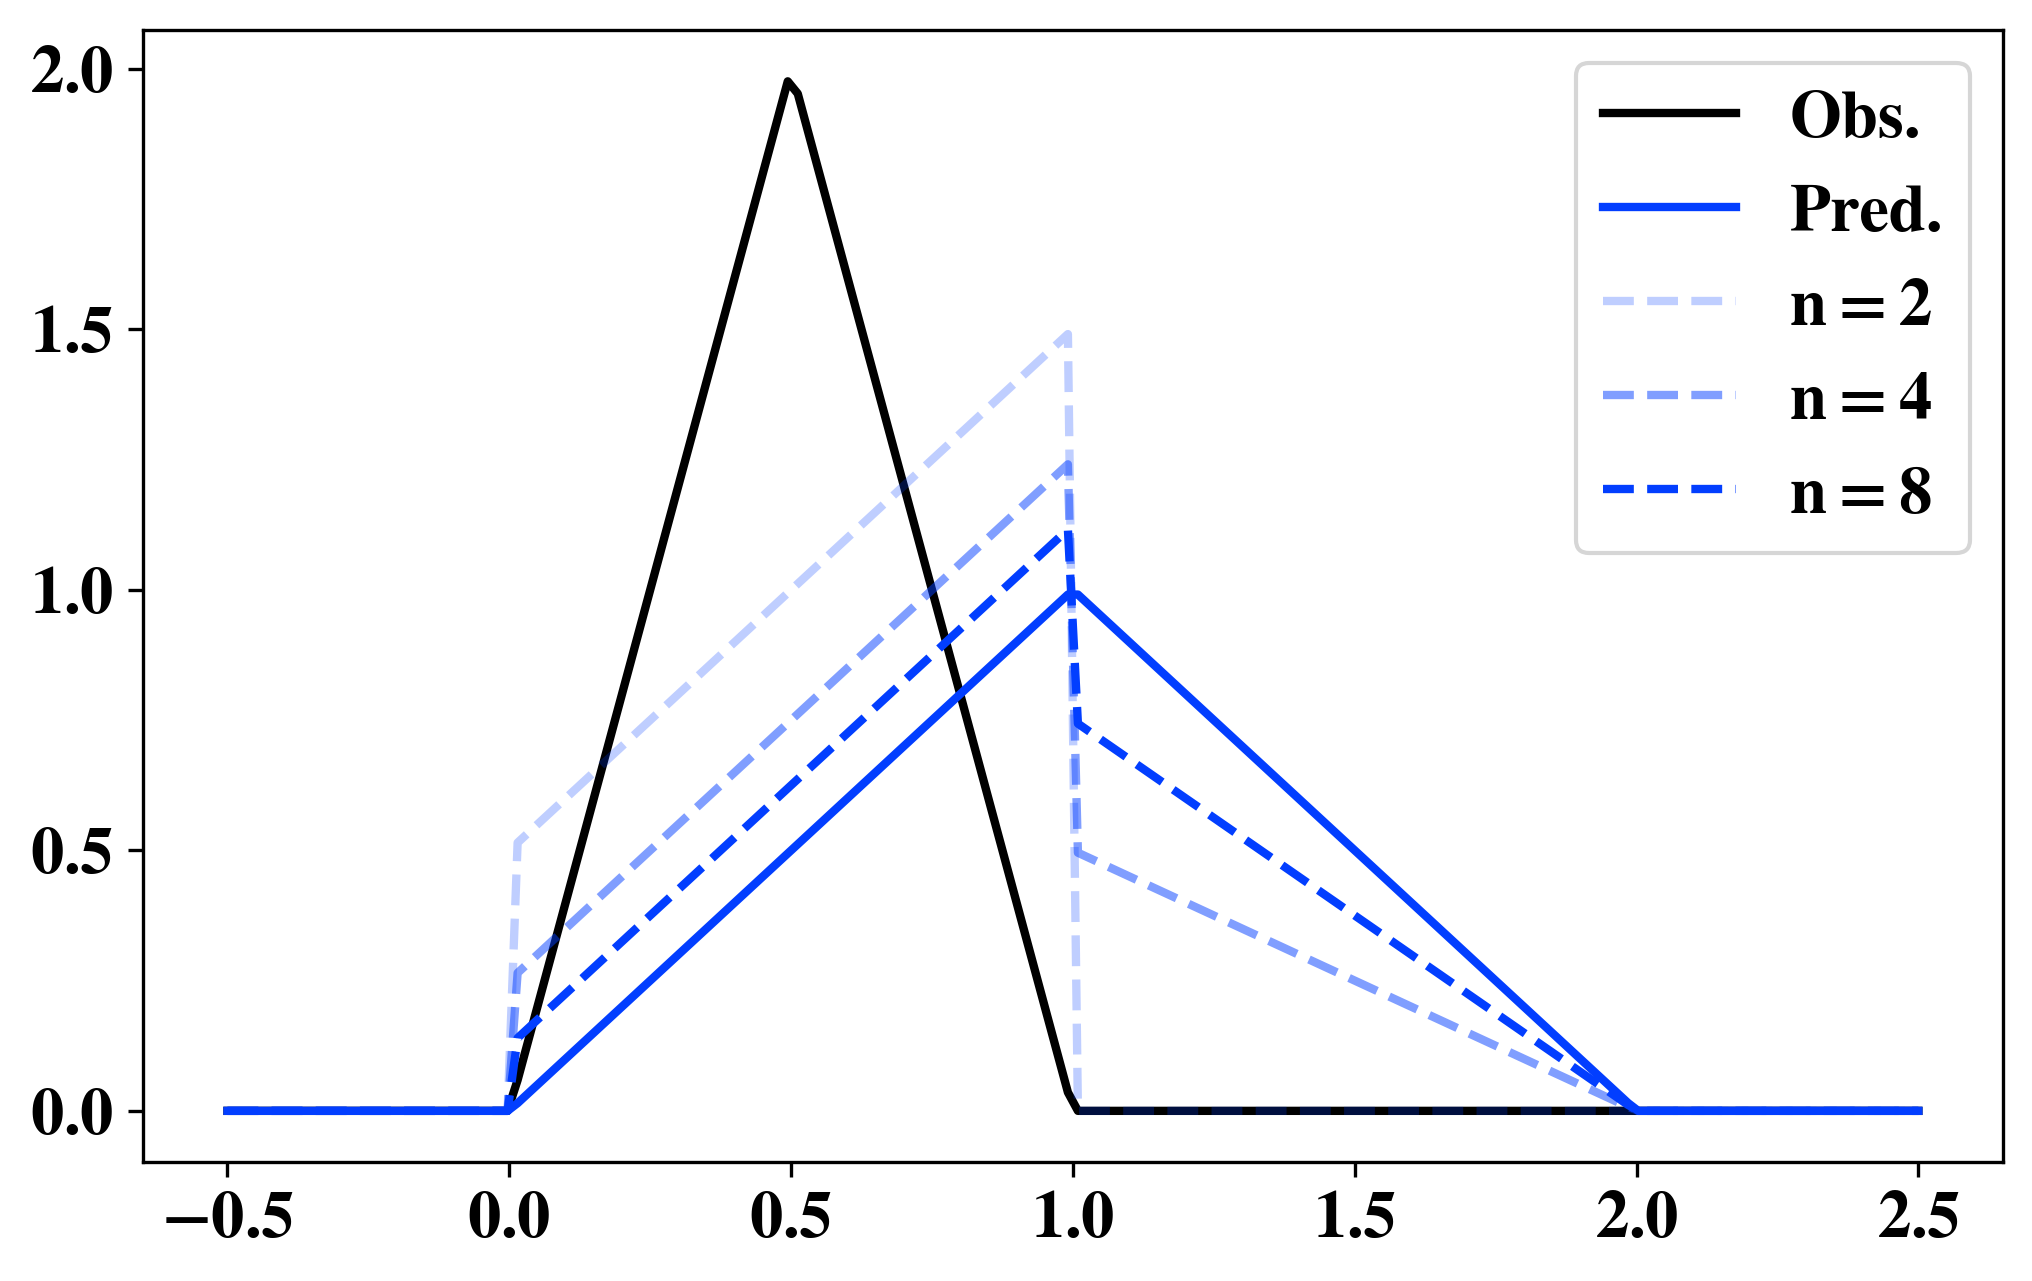

In [34]:
qx = np.linspace(-0.5,2.5,170)
pred_approx = approx_predict(1.,20)

ex2_fig_setup, ax = plt.subplots(1)
ex2_fig_setup.set_figwidth(2*fsize)
ax.plot(qx,obs_dist.pdf(qx),label='Obs.',color='k')
ax.plot(qx,pred_dist.pdf(qx),label='Pred.',color='C0')

for n in [2,4,8]:
    ax.plot(qx,pred_approx.pdf(qx,n),color='C0',
            ls='--',alpha=n/8,label='$n={}$'.format(n))
ax.legend()

name_ex2_fig_setup = 'ex2_fig_setup'
ex2_fig_setup.savefig(folder+name_ex2_fig_setup)

In [35]:
# check rate of convergence
p = 4
n_array = np.logspace(1,3.5,8)
mperr = np.zeros_like(n_array)

for i,n in enumerate(n_array):
    this_err = quad(lambda x: np.abs(pred_dist.pdf(x) - pred_approx.pdf(x,n))**p,
                    0,2)[0]
    mperr[i] = this_err


-3.9999999999999867


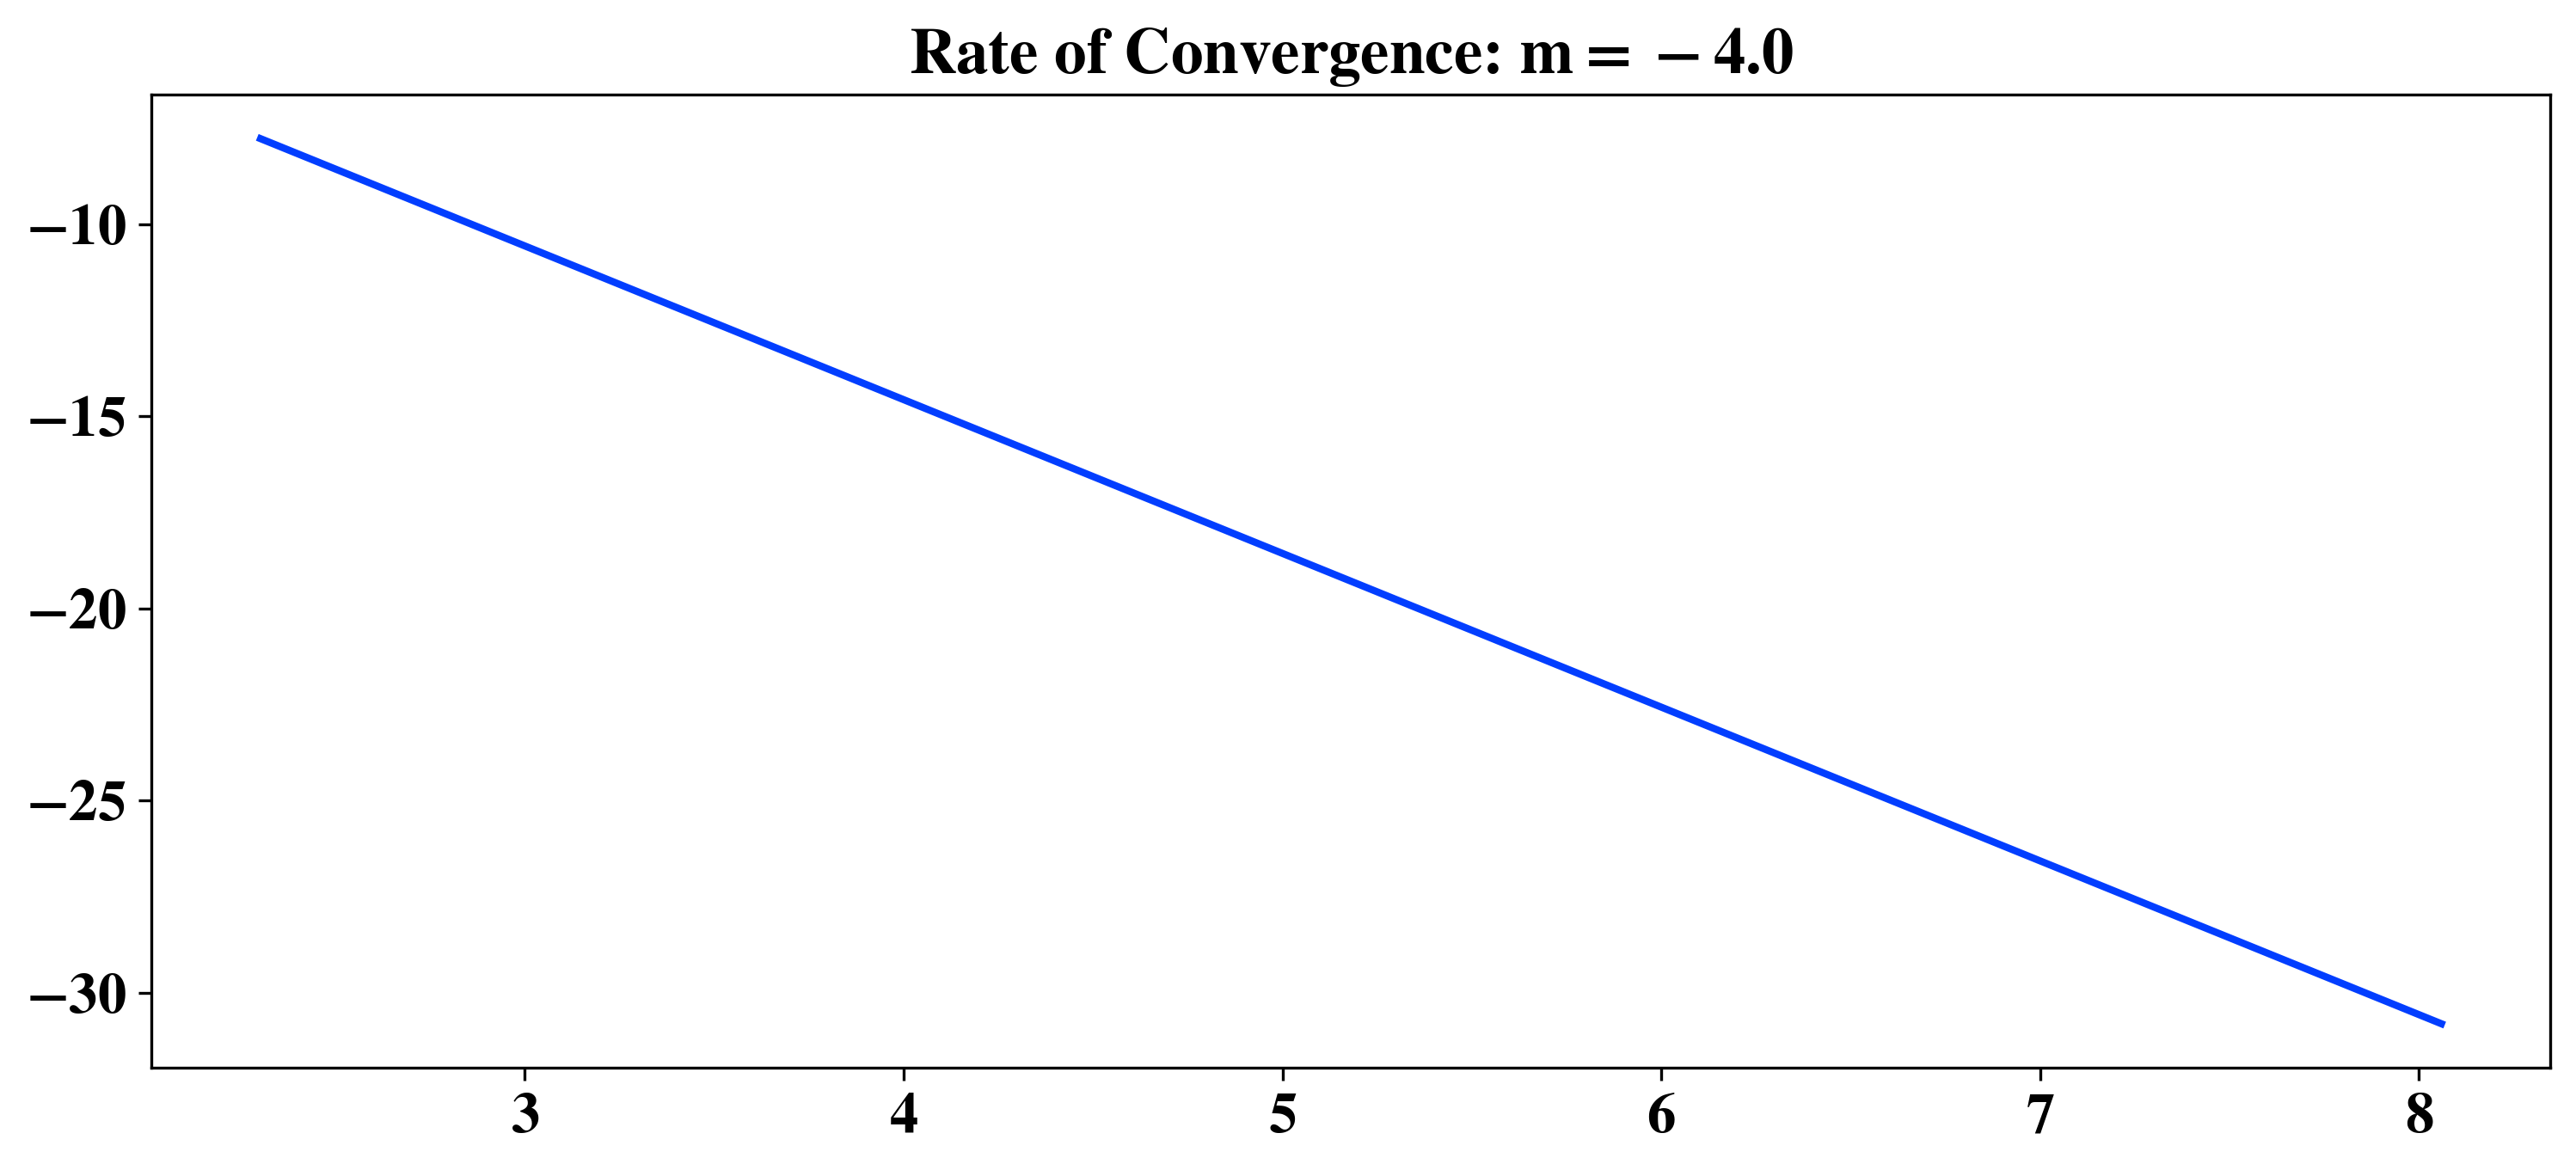

In [36]:
out = sps.linregress(np.log(n_array),np.log(mperr))
print(out.slope)
plt.title('Rate of Convergence: $m={:0.2}$'.format(out.slope))
plt.plot(np.log(n_array),np.log(mperr))

In [37]:
lamx,lamy = [np.linspace(-0.1,1.1,950+i) for i in range(2)]
lamX,lamY = np.meshgrid(lamx,lamy)
lamXY_eval = np.stack([lamX.reshape(-1,),lamY.reshape(-1,)],axis=1)

In [38]:
init_pdf = init_dist.pdf(lamXY_eval).reshape(lamX.shape)
pred_approx = approx_predict(1.,20)

update_exact = dci_update(init_dist,pred_dist,obs_dist,Qmap)
update_approx = dci_update(init_dist,pred_approx,obs_dist,Qmap)

# compute update and approx update
update_pdf = update_exact.pdf(lamXY_eval).reshape(lamX.shape)
update_approx_pdf = update_approx.pdf(lamXY_eval).reshape(lamX.shape)


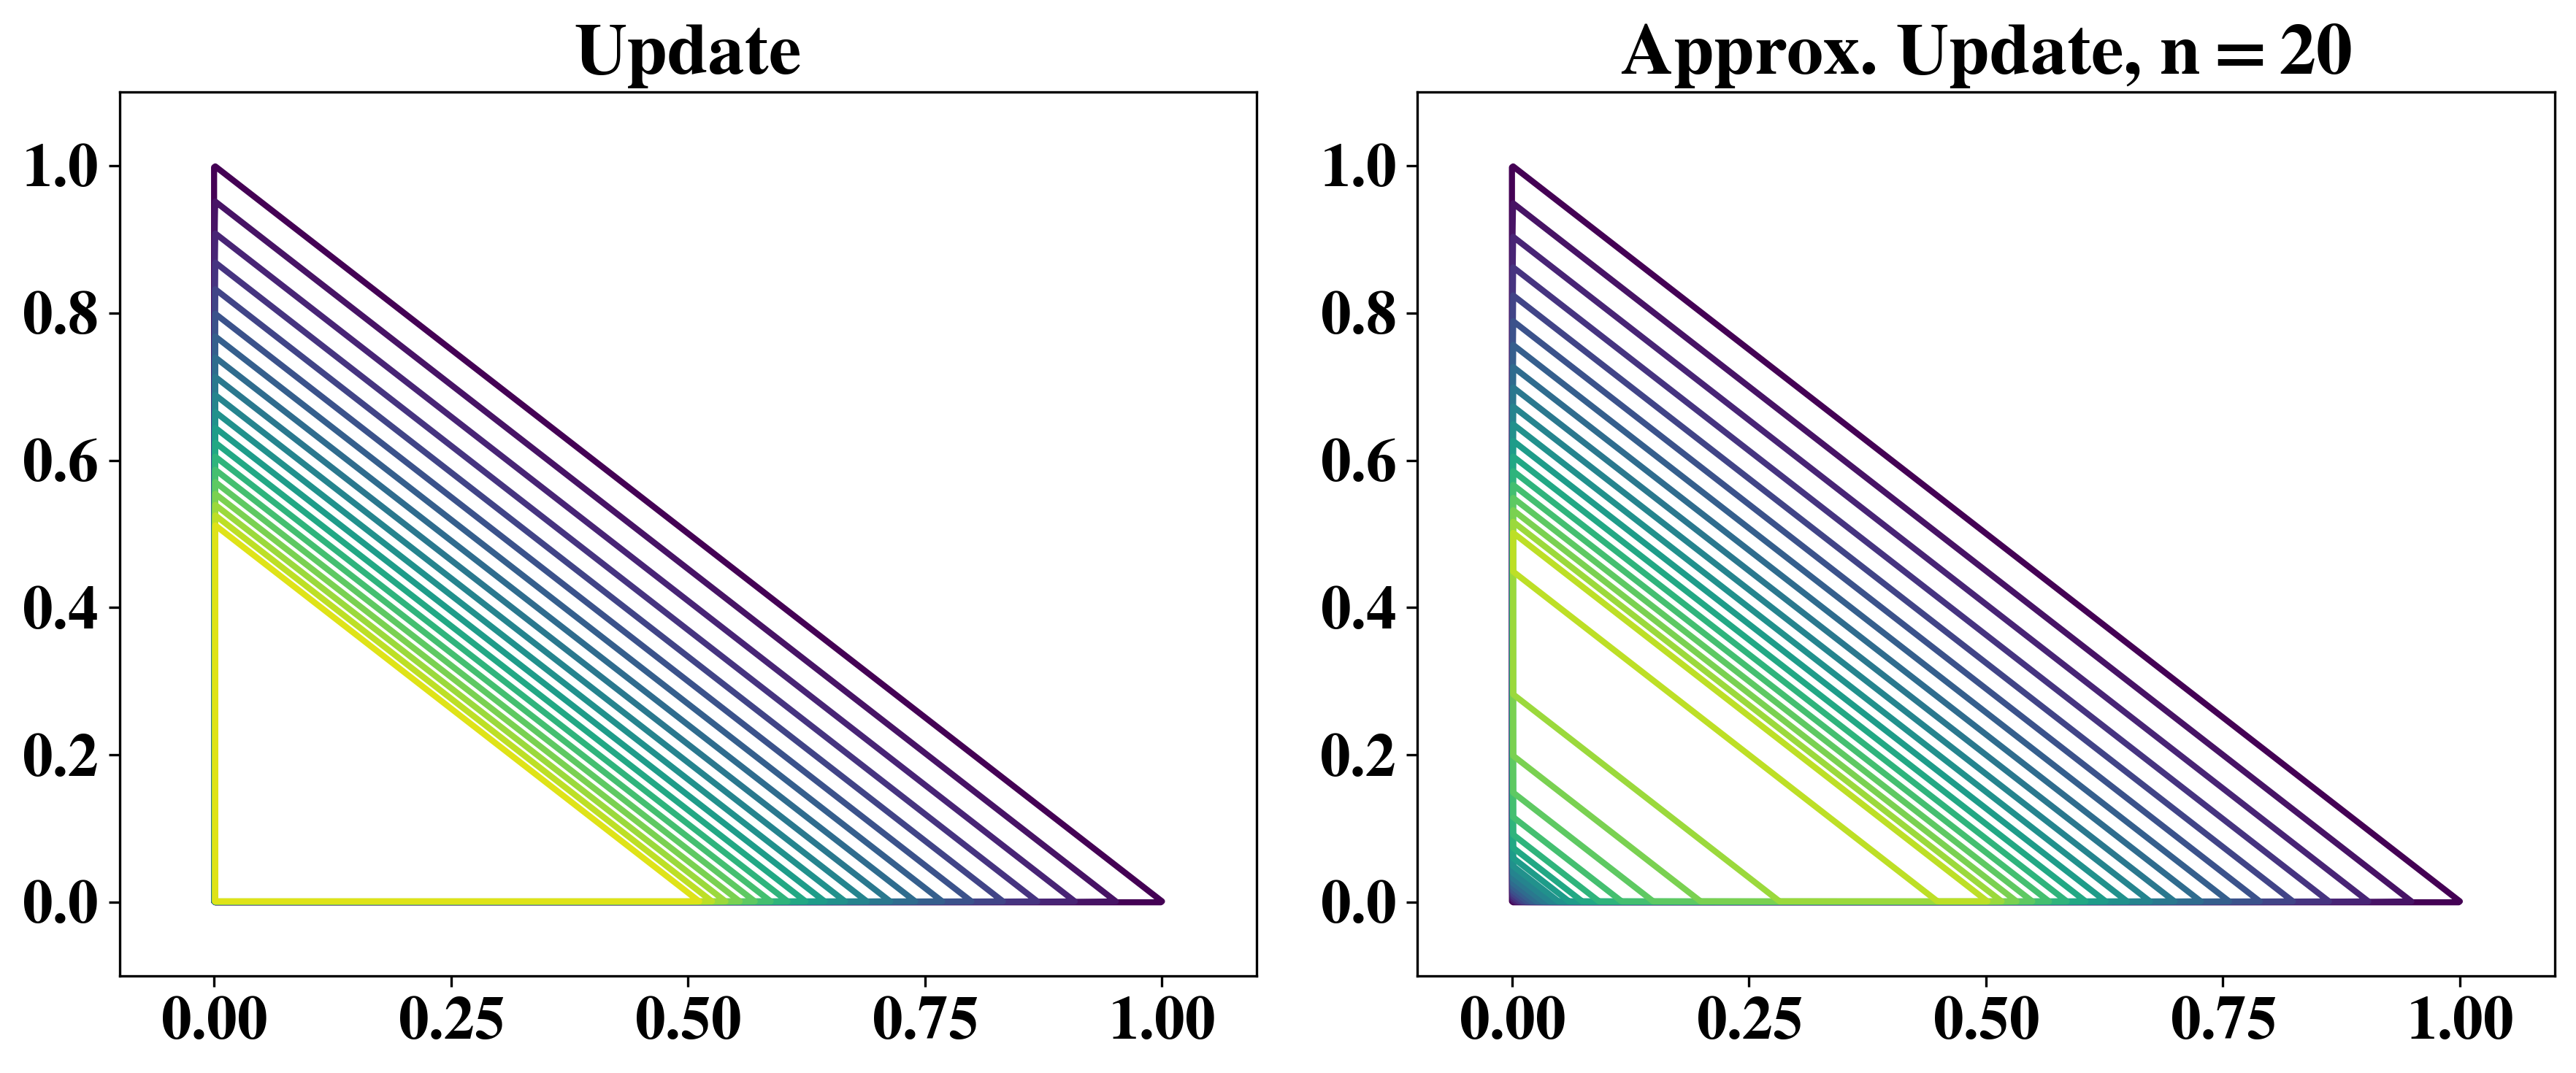

In [39]:
ex2_fig_update,axes = plt.subplots(1,2)
ex2_fig_update.set_figwidth(3*fsize)

pdf_list = [update_pdf,update_approx_pdf]
plt_min,plt_max = (np.array(pdf_list).min(),np.array(pdf_list).max())
for i,(ax,pdf) in enumerate(zip(axes,pdf_list)):
    ax.contour(lamX,lamY,pdf,vmin=plt_min,vmax=plt_max,levels=20)
    ax.set_title(['Update','Approx. Update, $n=20$'][i],fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
name_ex2_fig_update = 'ex2_fig_update'
ex2_fig_update.tight_layout()
ex2_fig_update.savefig(folder+name_ex2_fig_update)

In [40]:
def Lp_err(x,dist1,dist2,p):
    return np.abs(dist1.pdf(x)-dist2.pdf(x))**p

In [41]:
update_exact = dci_update(init_dist,pred_dist,obs_dist,Qmap)

n_array = np.geomspace(20,10**3.5,8)
mperr = np.zeros_like(n_array)
up_mperr = np.zeros_like(n_array)

for i,n in enumerate(n_array):
    pred_approx = approx_predict(1.,n)
    
    # approximation error of predicted
    this_err = quad(lambda x: Lp_err(x,pred_dist,pred_approx,p),0,2)[0]
    mperr[i] = this_err
    
    # approximation error of updates
    update_approx = dci_update(init_dist,pred_approx,obs_dist,Qmap)
    this_Lp_err = Lp_err(lamXY_eval,update_exact,update_approx,p).reshape(lamX.shape)
    up_err = simpson(simpson(this_Lp_err,lamx),lamy)
    up_mperr[i] = up_err


# simpson(simpson(np.abs(update_pdf-update_approx_pdf)**p,lamx),lamy)

-3.999999999999984
-2.6102923739182344


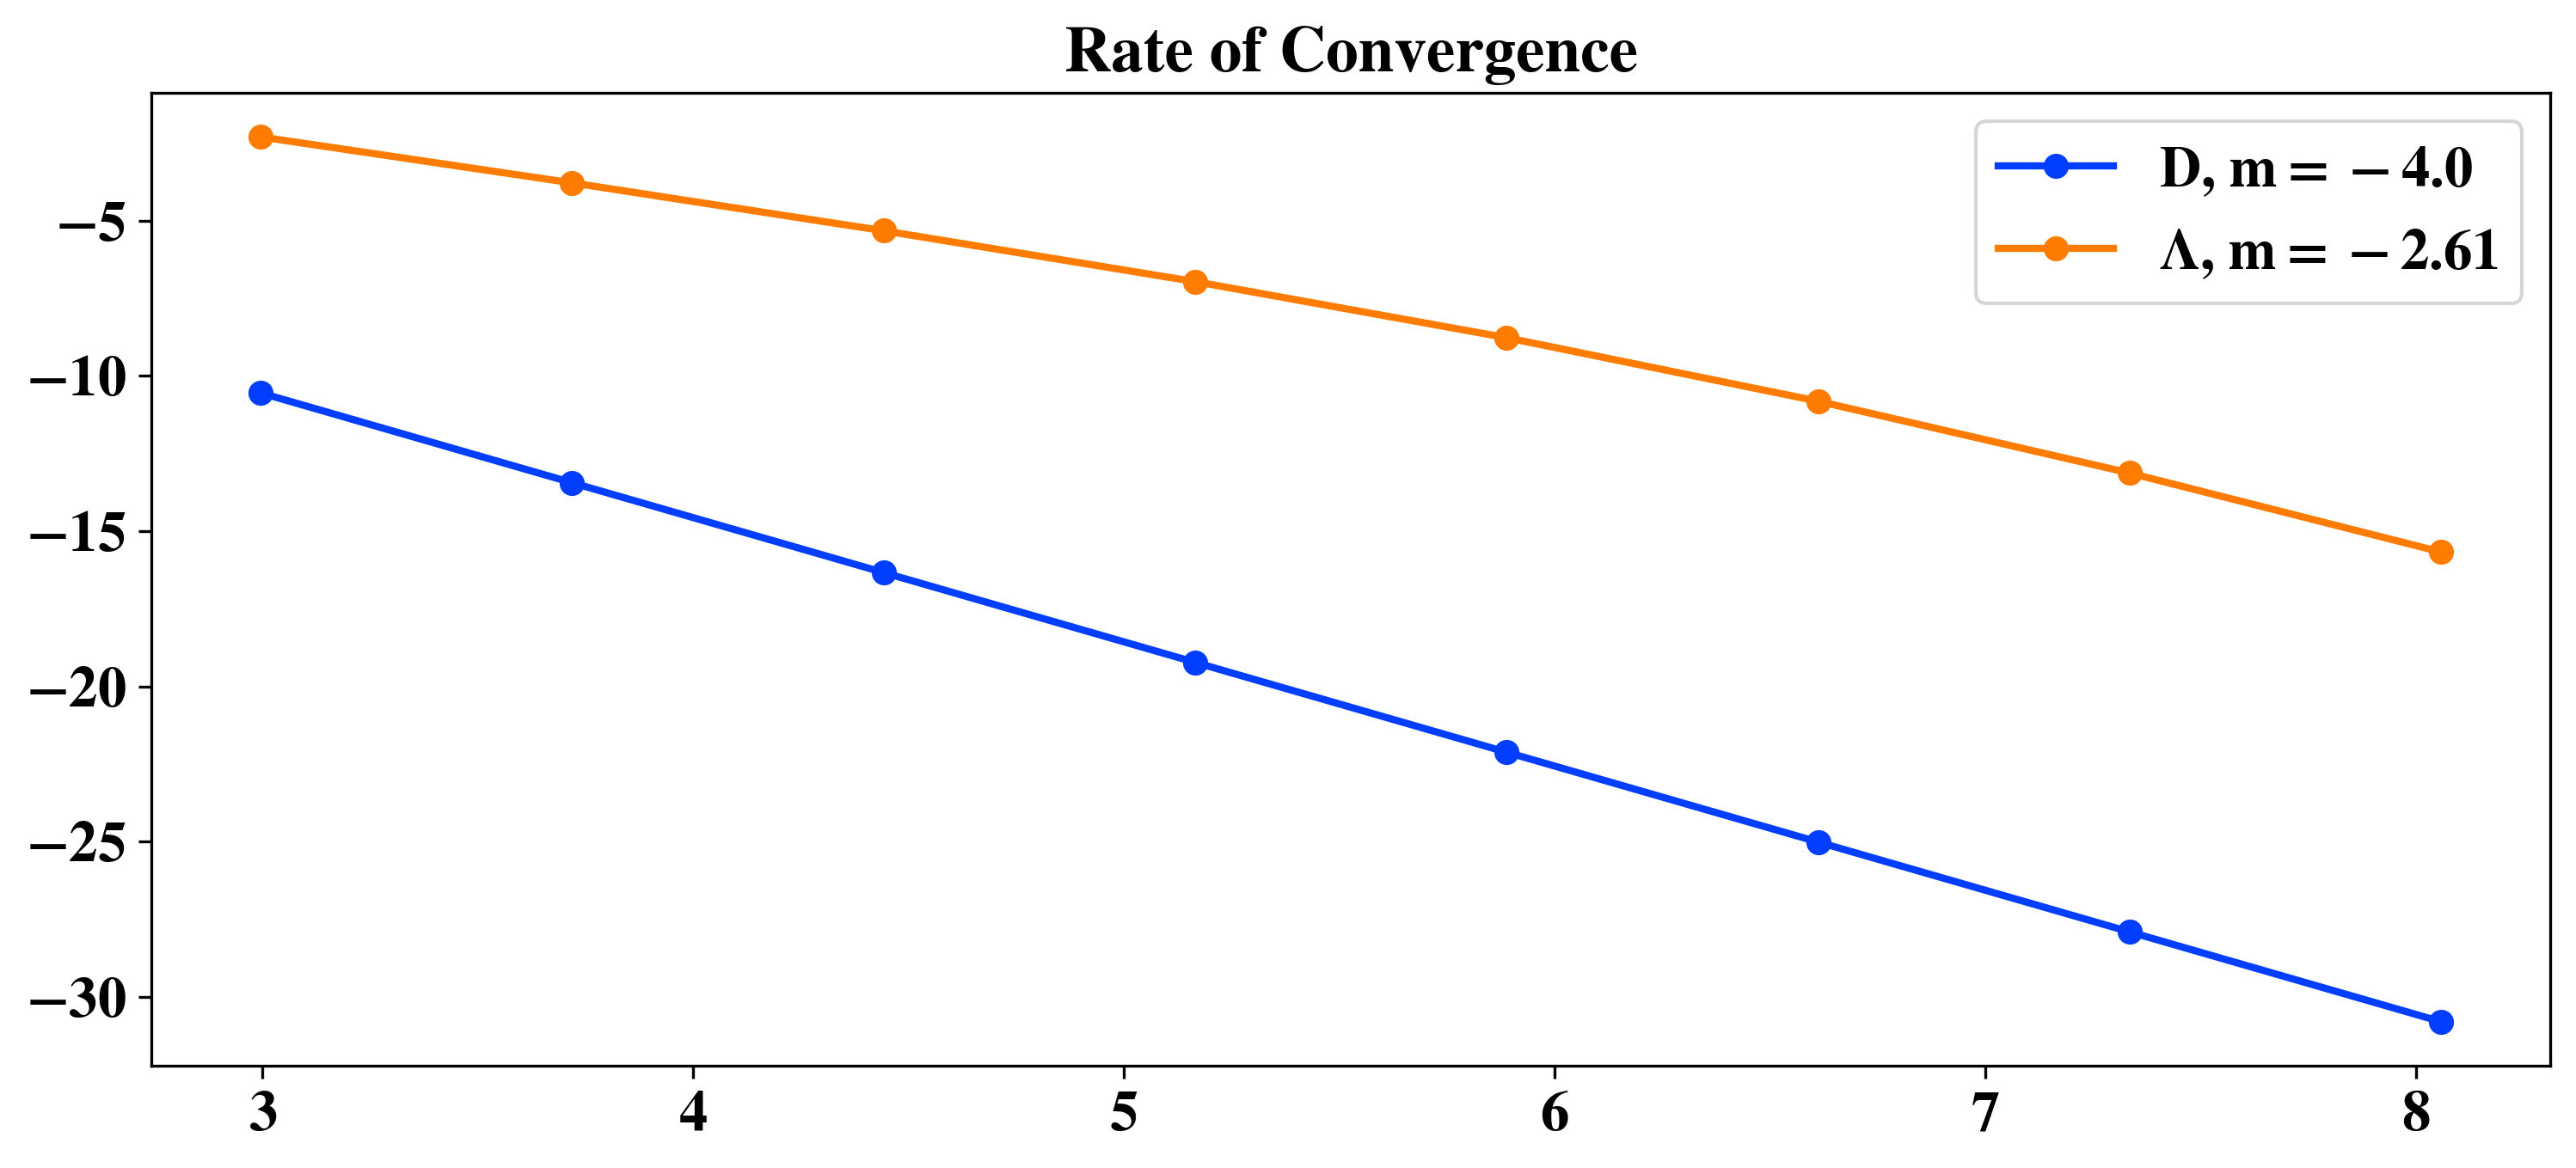

In [42]:
out_q = sps.linregress(np.log(n_array),np.log(mperr))
out_lam = sps.linregress(np.log(n_array),np.log(up_mperr))
print(out_q.slope)
print(out_lam.slope)

plt.title('Rate of Convergence')
plt.plot(np.log(n_array),np.log(mperr),marker='o',
         label='$D$, $m={:0.3}$'.format(out_q.slope))
plt.plot(np.log(n_array),np.log(up_mperr),marker='o',
         label='$\\Lambda$, $m={:0.3}$'.format(out_lam.slope))
plt.legend()

**Cut Domain Into Pieces**

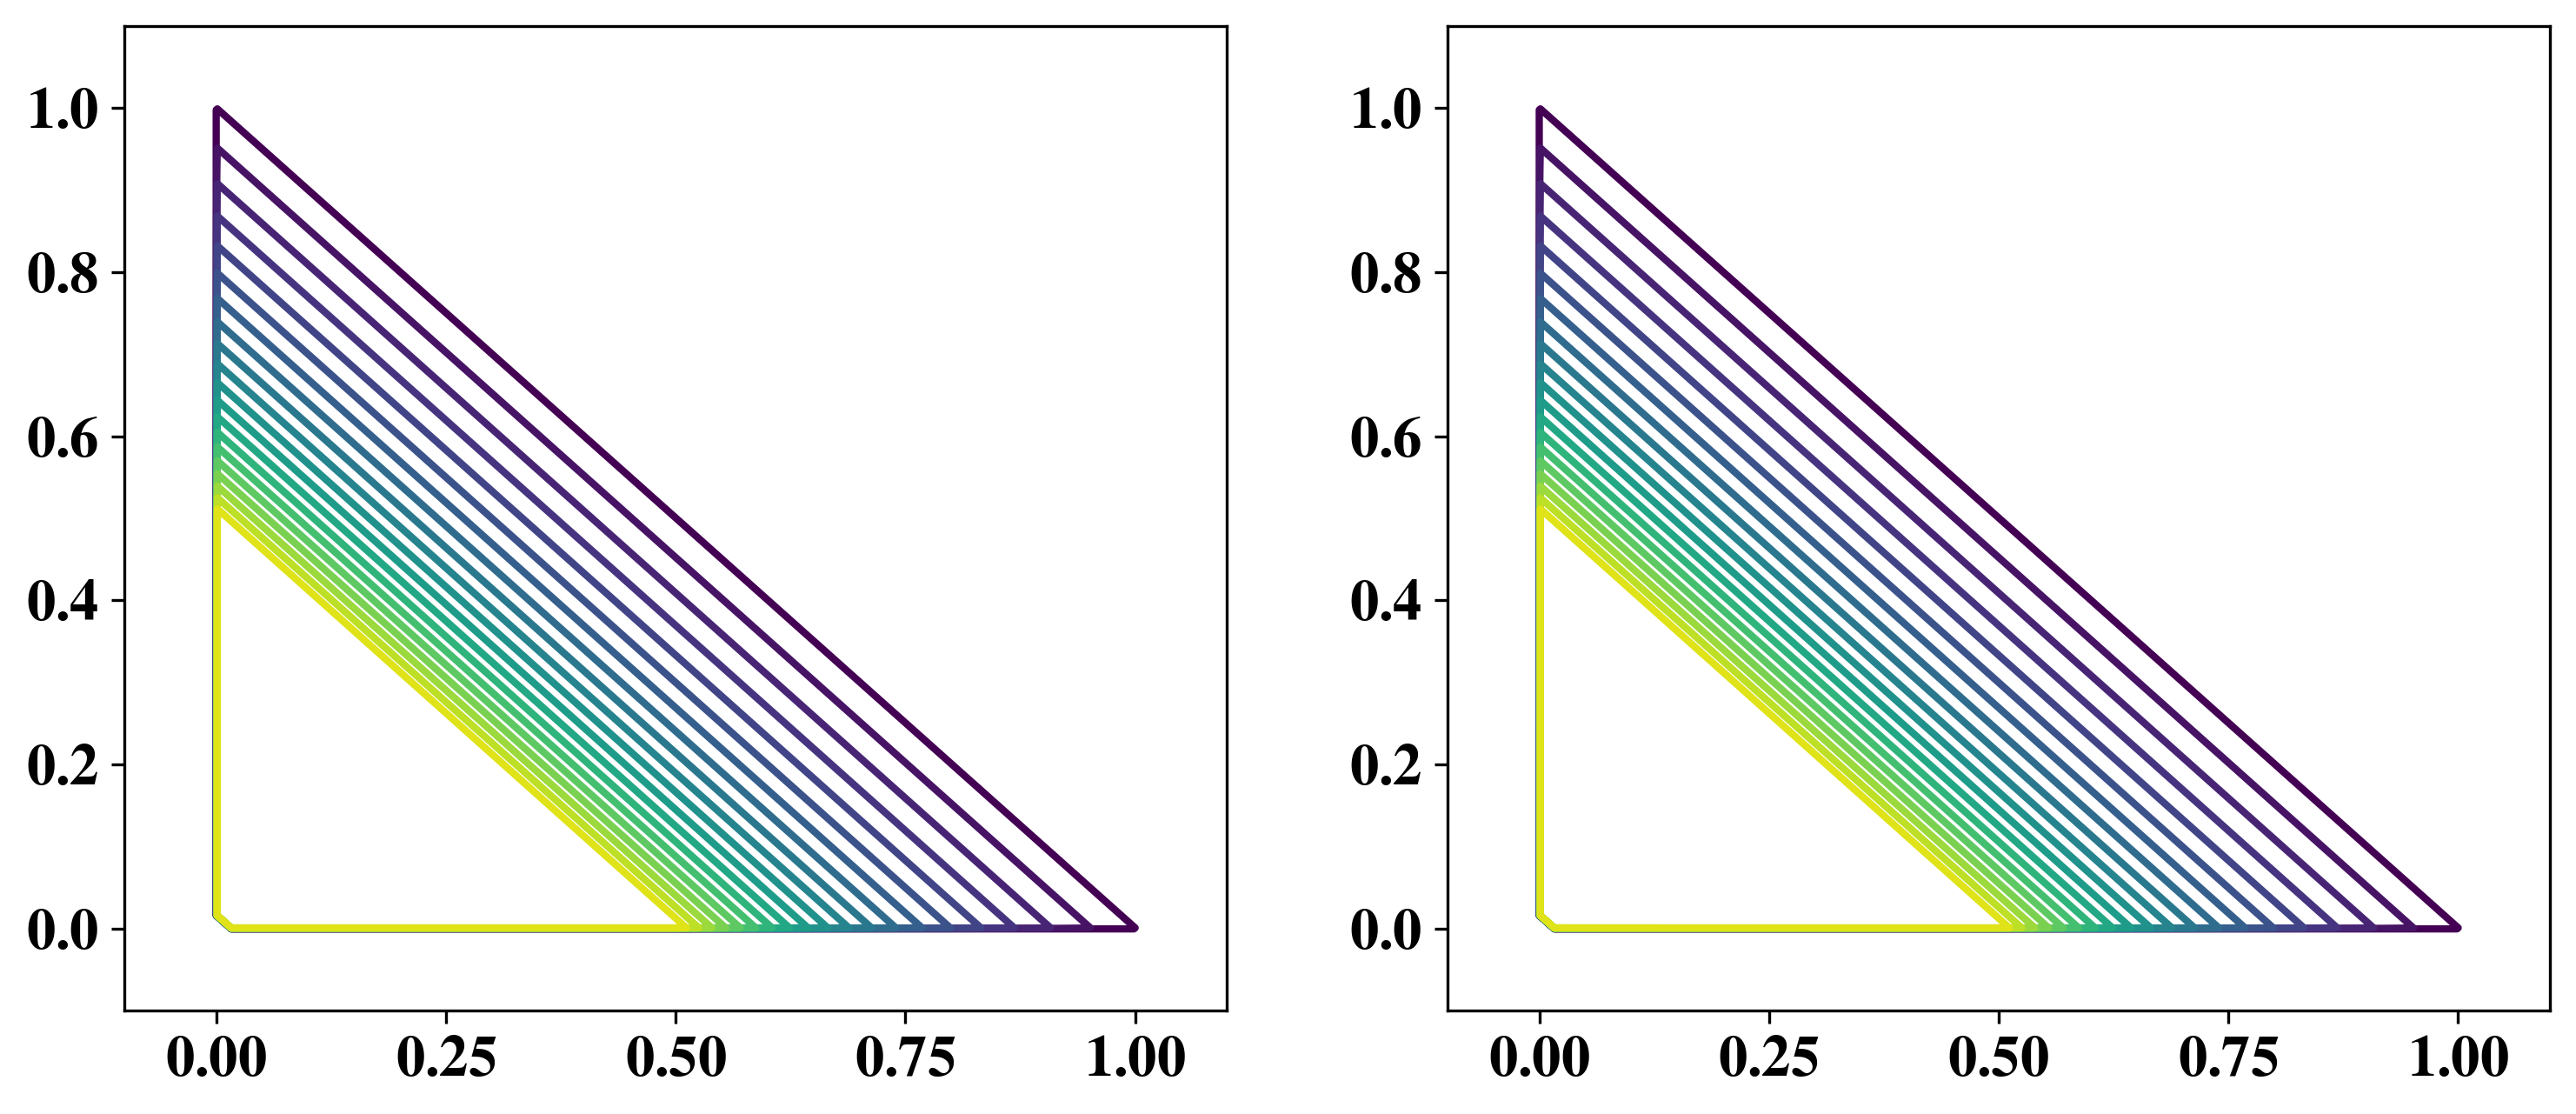

In [59]:
delta = 0.017
zeros = lamX<delta-lamY
update_pdf = update_exact.pdf(lamXY_eval).reshape(lamX.shape)
update_approx_pdf = update_approx.pdf(lamXY_eval).reshape(lamX.shape)
update_pdf[zeros] = 0.
update_approx_pdf[zeros] = 0.

fig,axes = plt.subplots(1,2)

pdf_list = [update_pdf,update_approx_pdf]
plt_min,plt_max = (np.array(pdf_list).min(),np.array(pdf_list).max())
for ax,pdf in zip(axes,pdf_list):
    ax.contour(lamX,lamY,pdf,vmin=plt_min,vmax=plt_max,levels=20)

Choose $\delta$ so that,
\begin{align}
A_\delta := \{ q: \pi^{predict}(q)\leq \delta\} \\
\int_{A_\delta} \pi^{predict}(q) d\mu_D < \frac{\epsilon}{C}
\end{align}

Here we know that $C=4$ for the predictability assumption to be satisfied, since
\begin{align}
\dfrac{\pi^{obs}(q)}{\pi^{predict}(q)} &= \dfrac{4q}{q} \leq 4
\end{align}

within the support of the observed, $[0,1]$.

Thus, we can determine a set $A_\delta$ using the following integral,
\begin{align}
\int_{A_\delta} \pi^{predict}(q) d\mu_D &= \int_{0}^{q_\delta} q d\mu_D\\
&= \left. \frac{q^2}{2}\right|_0^{q_\delta} \\
&= \frac{q_\delta^2}{2} < \frac{\epsilon}{4} \\
\Rightarrow\quad q_\delta=\delta &< \sqrt{\frac{\epsilon}{2}}\Rightarrow \int_{A_\delta} \pi^{predict}(q) d\mu_D < \frac{\epsilon}{4}
\end{align}


In [62]:
eps = 0.01
delta = np.sqrt(eps/2)
print(delta)
zeros_A = lamX<delta-lamY

mperr_nA = np.zeros_like(n_array)
up_mperr_nA = np.zeros_like(n_array)

for i,n in enumerate(n_array):
    pred_approx = approx_predict(1.,n)
    
    # approximation error of predicted
    this_err = quad(lambda x: Lp_err(x,pred_dist,pred_approx,p),delta,2)[0]
    mperr_nA[i] = this_err
    
    # approximation error of updates
    update_approx = dci_update(init_dist,pred_approx,obs_dist,Qmap)
    this_Lp_err = Lp_err(lamXY_eval,update_exact,update_approx,p).reshape(lamX.shape)
    this_Lp_err[zeros_A] = 0.
    up_err = simpson(simpson(this_Lp_err,lamx),lamy)
    up_mperr_nA[i] = up_err


# simpson(simpson(np.abs(update_pdf-update_approx_pdf)**p,lamx),lamy)

0.07071067811865475


-0.9999999999999957
-0.6525730934795586
-0.93877991119018


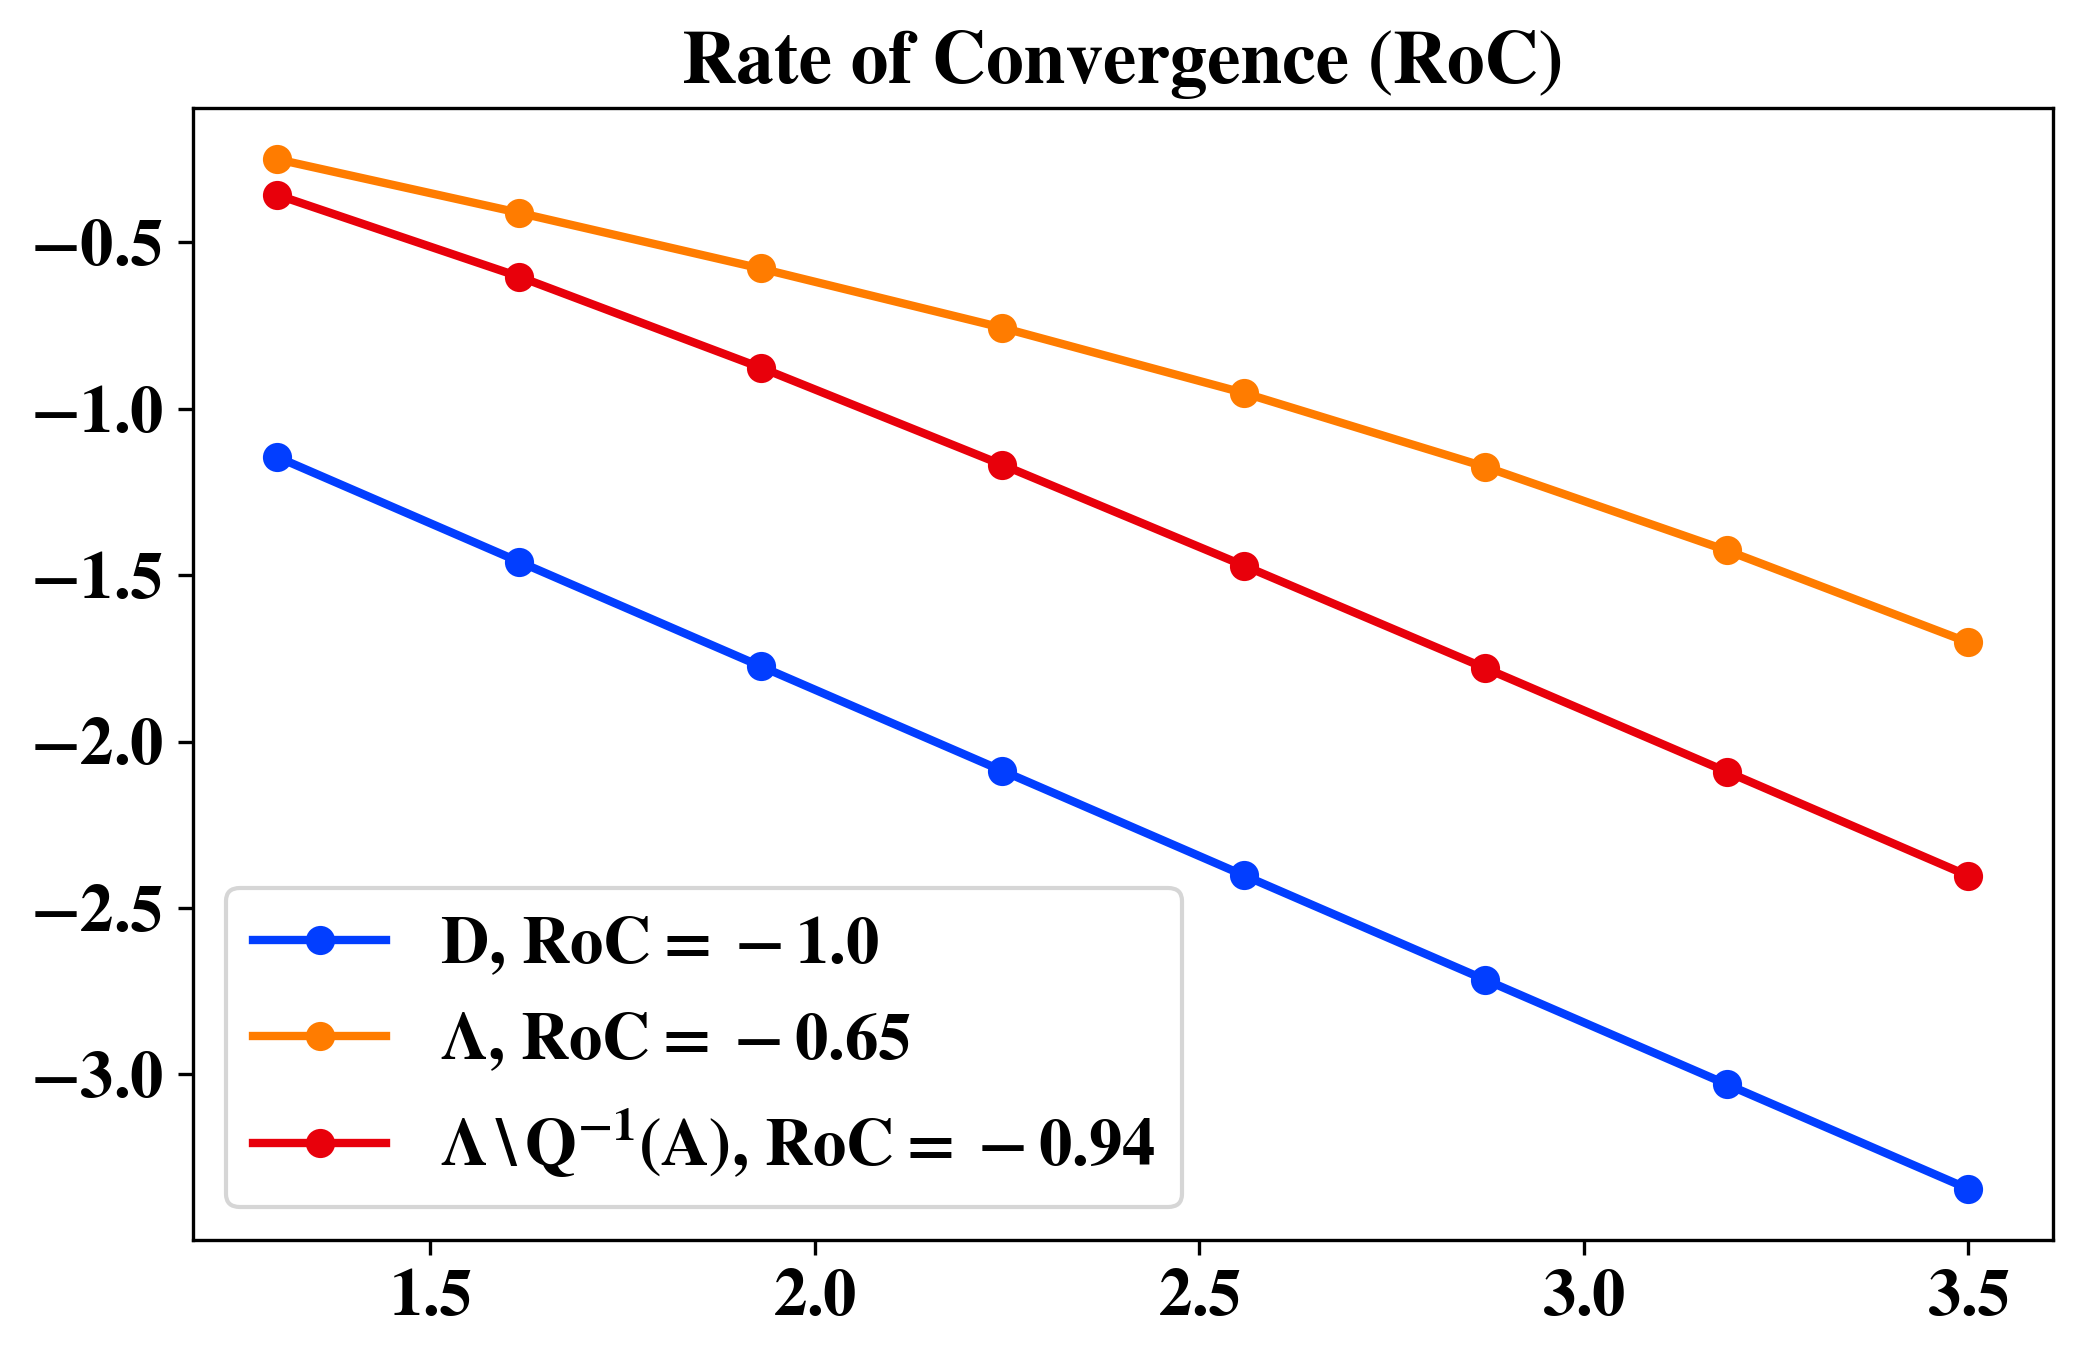

In [67]:
ex2_fig_convergence, ax = plt.subplots(1)
ex2_fig_convergence.set_figwidth(2*fsize)

out_q = sps.linregress(np.log10(n_array),np.log10(mperr)/4)
out_lam = sps.linregress(np.log10(n_array),np.log10(up_mperr)/4)
out_lam_nA = sps.linregress(np.log10(n_array),np.log10(up_mperr_nA)/4)
print(out_q.slope)
print(out_lam.slope)
print(out_lam_nA.slope)

ax.set_title('Rate of Convergence (RoC)')
ax.plot(np.log10(n_array),np.log10(mperr)/4,marker='o',
         label='$D$, $RoC={:0.2}$'.format(out_q.slope))
ax.plot(np.log10(n_array),np.log10(up_mperr)/4,marker='o',
         label='$\\Lambda$, $RoC={:0.2}$'.format(out_lam.slope))
# plt.plot(np.log(n_array),np.log(mperr),marker='o',
#          label='$D-A$, $m={:0.2}$'.format(out_q.slope))
ax.plot(np.log10(n_array),np.log10(up_mperr_nA)/4,marker='o',color='C3',
         label='$\\Lambda\\,\\backslash\\, Q^{{ -1 }}(A)$, $RoC={:0.2}$'.format(out_lam_nA.slope))

ax.legend(loc='lower left')
name_ex2_fig_convergence = 'ex2_fig_convergence'
ex2_fig_convergence.savefig(folder+name_ex2_fig_convergence)

**Linear Kernel FUNCTION?**

In [43]:
pred_tkde = KernelDensity(kernel='linear')
this_SS = ShuffleSplit(n_splits=10,test_size=0.2)
this_search = GridSearchCV(pred_tkde,{'bandwidth': np.logspace(-5,1)},cv=this_SS,
                           refit=False)
this_search.fit(q_pred.reshape(-1,1))
print(this_search.best_params_)
pred_tkde.bandwidth = this_search.best_params_['bandwidth']
pred_tkde.fit(q_pred.reshape(-1,1))

{'bandwidth': 0.08286427728546843}


/Users/rylanspence/mambaforge/envs/dci_da/lib/python3.11/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf  -506.09204001
  -504.25901479  -503.41004029  -502.88978677  -502.25290866
  -501.89005703  -501.89641637  -502.38720626  -503.70570289
  -506.27341758  -511.50920956  -521.39832089  -539.79994804
  -574.35188132  -638.74591427  -748.18709858  -907.50182091
 -1106.58929955 -1331.00628203 -1571.952531   -1824.18936637
 -2084.36554988 -2350.23471453]
  warnings.warn(
/Users/rylanspence/mambaforge/envs/dci_da/lib/py

KernelDensity(bandwidth=0.08286427728546843, kernel='linear')

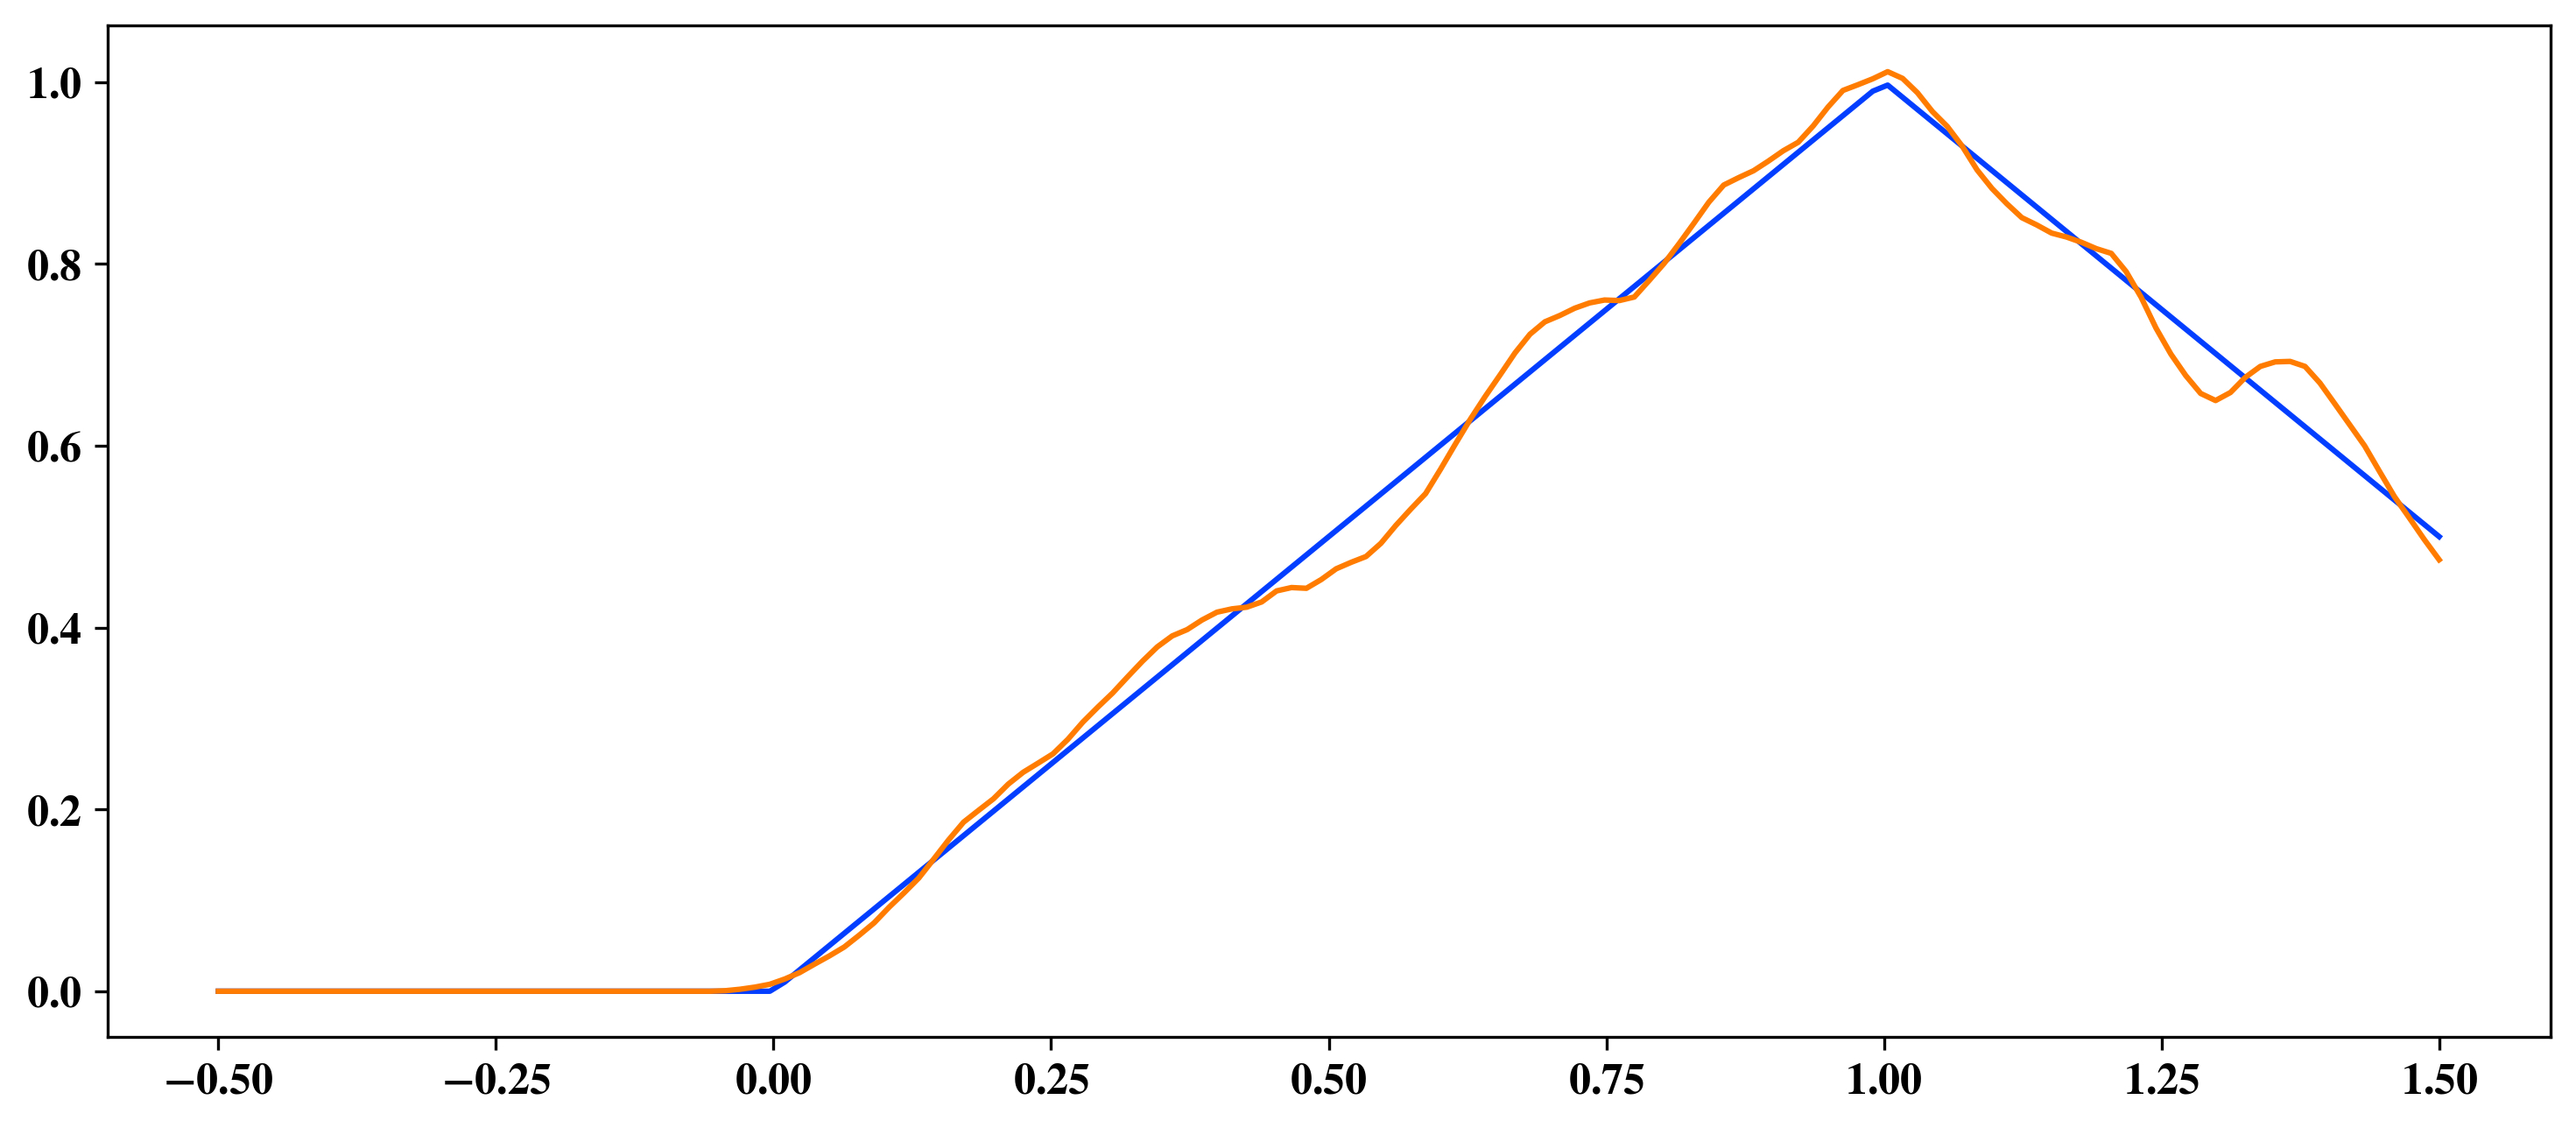

In [44]:
x = np.linspace(-0.5,1.5,150)
y = np.squeeze(np.exp(pred_tkde.score_samples(x.reshape(-1,1))))
plt.plot(x,pred_dist.pdf(x))
plt.plot(x,y)

In [45]:
x[35],y[35]

(-0.030201342281879207, 0.0021860893740367877)